<a href="https://colab.research.google.com/github/EmelyanovAndreyNSK/PythonTasks/blob/master/HW_ML_3_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings

import numpy as np
import pandas as pd

import matplotlib.pylab as plt
import seaborn as sns

from tqdm import tqdm

import sklearn

import plotly.express as px
import statsmodels.api as sm

from sklearn.datasets import make_blobs, make_circles
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree, export_text, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering

from sklearn.manifold import TSNE

In [ ]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv

--2021-12-25 15:37:29--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6220 (6.1K) [text/plain]
Saving to: ‘daily-total-female-births.csv.3’

daily-total-female- 100%[===================>]   6.07K  --.-KB/s    in 0s      

2021-12-25 15:37:29 (49.2 MB/s) - ‘daily-total-female-births.csv.3’ saved [6220/6220]



### EDA

In [ ]:
data = pd.read_csv('daily-total-female-births.csv')
data.sort_values('Date')
data.head()

,Date,Births
0,1959-01-01,35
1,1959-01-02,32
2,1959-01-03,30
3,1959-01-04,31
4,1959-01-05,44


In [ ]:
print(max(data['Date']))
print(min(data['Date']))

print(len(data['Date']))

1959-12-31
1959-01-01
365


In [ ]:
fig = px.line(data, x="Date", y="Births", title='Minimum births')
fig.show()

In [ ]:
fig = px.line(data[data.Date < '1960-01-01'], x="Date", y="Births", title='Minimum births')
fig.show()

In [ ]:
data['Births_diff_1'] = data.Births.diff(1)
fig = px.line(data, x="Date", y="Births_diff_1", title='Minimum temperature diff 1')
fig.show()

In [ ]:
data['Births_diff_1'] = data.Births.diff(1)
fig = px.line(data[data.Date < '1960-01-01'], x="Date", y="Births_diff_1", title='Minimum births diff 1')
fig.show()

In [ ]:
data['Births_diff_2'] = data.Births.diff(2)
fig = px.line(data[data.Date < '1960-01-01'], x="Date", y="Births_diff_2", title='Births temperature diff 2')
fig.show()

### Стационарность

In [ ]:
def test_stationarity(data):
    test = sm.tsa.adfuller(data)

    print('adf: ', round(test[0], 5)) 
    print('p-value: ', round(test[1], 5))

    if test[0]> test[4]['5%']: 
        raise ValueError('WARNING: ряд не стационарен')

#### Начальный ряд

In [ ]:
test_stationarity(data['Births'])

adf:  -4.80829
p-value:  5e-05


In [ ]:
test_stationarity(data[data.Date < '1960-01-01']['Births'])

adf:  -4.80829
p-value:  5e-05


#### Ряд первых разностей

In [ ]:
test_stationarity(data['Births_diff_1'].dropna())

adf:  -12.62518
p-value:  0.0


In [ ]:
test_stationarity(data[data.Date < '1960-01-01']['Births_diff_1'].dropna())

adf:  -12.62518
p-value:  0.0


### Автокорреляция и частичная автокорреляция

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt



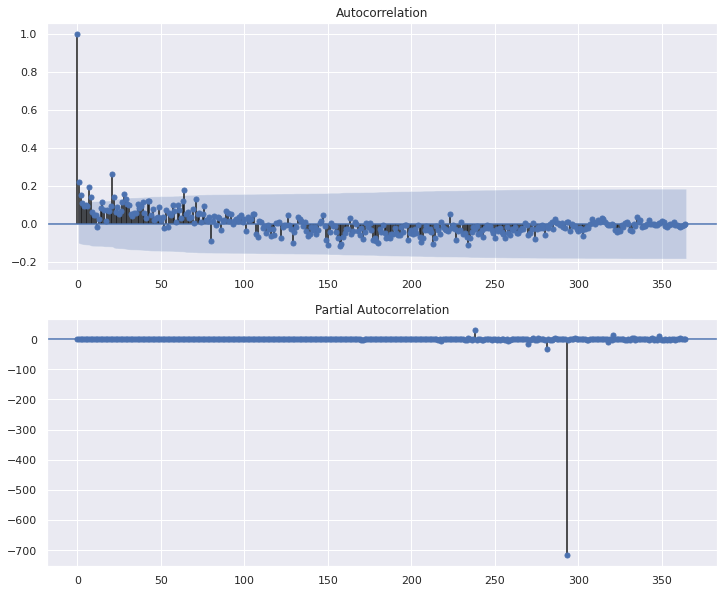

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


fig, ax = plt.subplots(2, figsize=(12,10))
ax[0] = plot_acf(data['Births'], ax=ax[0], lags=364)
ax[1] = plot_pacf(data['Births'], ax=ax[1], lags=364)

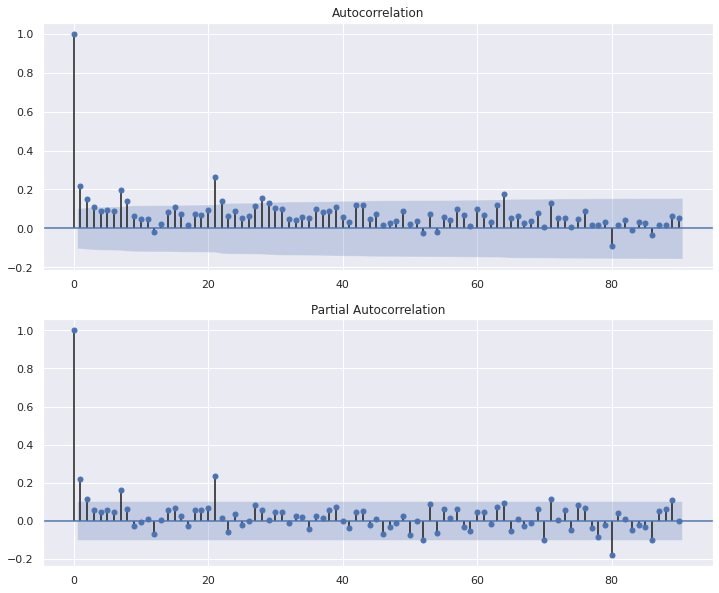

In [ ]:
fig, ax = plt.subplots(2, figsize=(12,10))
ax[0] = plot_acf(data['Births'], ax=ax[0], lags=90)
ax[1] = plot_pacf(data['Births'], ax=ax[1], lags=90)

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt



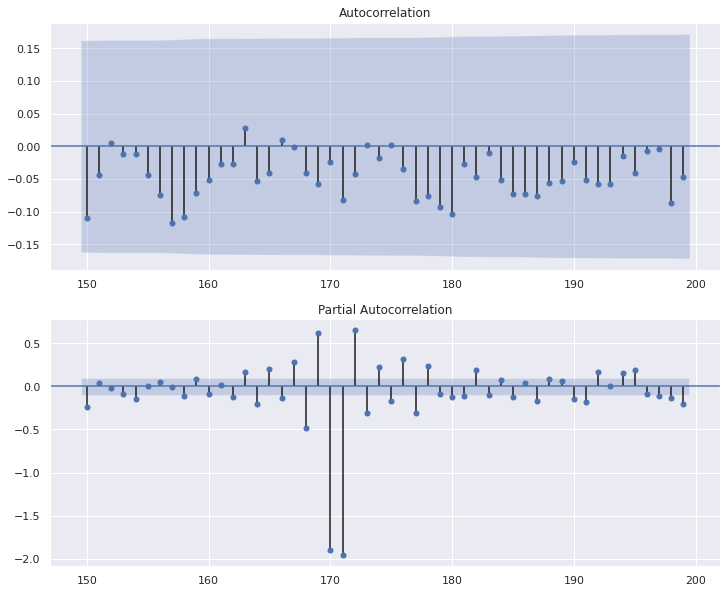

In [ ]:
fig, ax = plt.subplots(2, figsize=(12,10))
ax[0] = plot_acf(data['Births'], ax=ax[0], lags=np.arange(150, 200))
ax[1] = plot_pacf(data['Births'], ax=ax[1], lags=np.arange(150, 200))

### Тренды

In [ ]:
data.index = data['Date']
data.head()

,Date,Births,Births_diff_1,Births_diff_2
Date,,,,
1959-01-01,1959-01-01,35,NaN,NaN
1959-01-02,1959-01-02,32,-3.0,NaN
1959-01-03,1959-01-03,30,-2.0,-5.0
1959-01-04,1959-01-04,31,1.0,-1.0
1959-01-05,1959-01-05,44,13.0,14.0


#### Средненедельно и среднемесячное

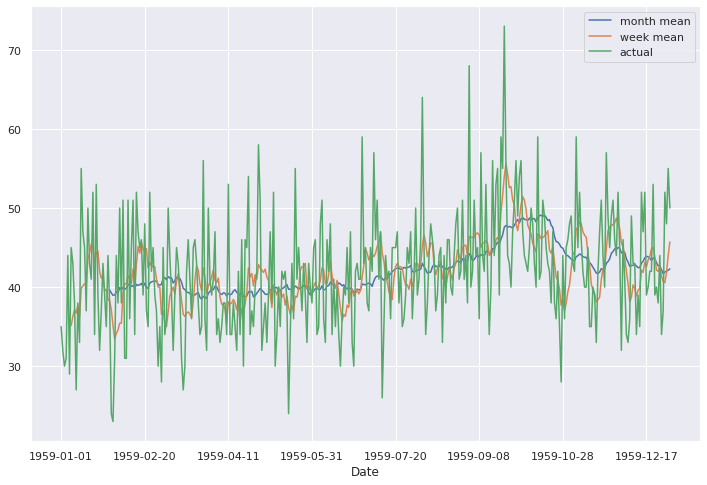

In [ ]:
sub_data = data[data.Date < '1960-01-01']
month_mean = sub_data['Births'].rolling(30).apply(np.mean)
week_mean = sub_data['Births'].rolling(7).apply(np.mean)

plt.figure(figsize=(12, 8))
month_mean.plot(label='month mean')
week_mean.plot(label='week mean')
sub_data['Births'].plot(label='actual')
plt.legend()
pass

#### Среднегодовое постоянно

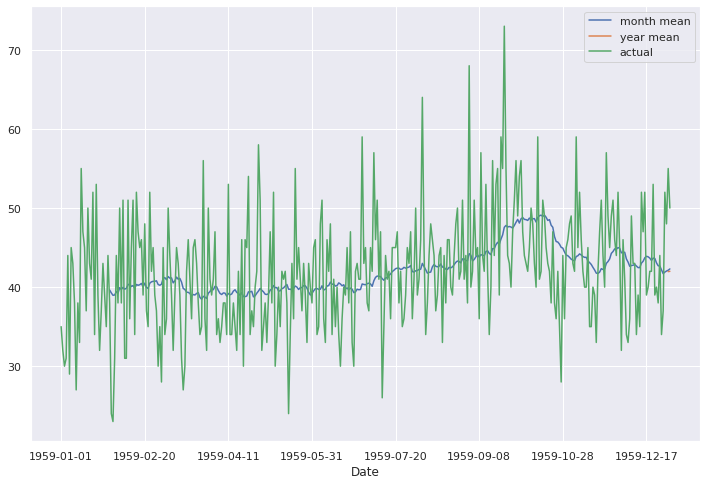

In [ ]:
sub_data = data[data.Date < '1960-01-02']
month_mean = sub_data['Births'].rolling(30).apply(np.mean)
year_mean = sub_data['Births'].rolling(364).apply(np.mean)

plt.figure(figsize=(12, 8))
month_mean.plot(label='month mean')
year_mean.plot(label='year mean')
sub_data['Births'].plot(label='actual')
plt.legend()
pass

#### Сравнение с медианой

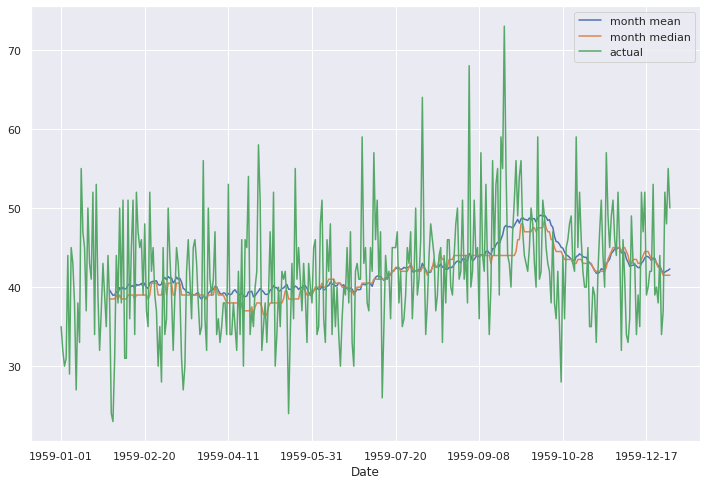

In [ ]:
sub_data = data[data.Date < '1982-01-01']
month_mean = sub_data['Births'].rolling(30).apply(np.mean)
month_median = sub_data['Births'].rolling(30).apply(np.median)

plt.figure(figsize=(12, 8))
month_mean.plot(label='month mean')
month_median.plot(label='month median')
sub_data['Births'].plot(label='actual')
plt.legend()
pass

#### Дисперсия

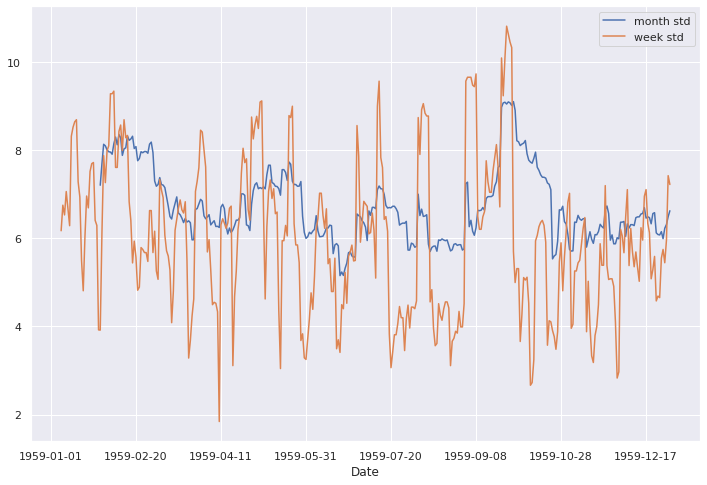

In [ ]:
sub_data = data[data.Date < '1982-01-01']
month_mean = sub_data['Births'].rolling(30).apply(np.std)
week_mean = sub_data['Births'].rolling(7).apply(np.std)

plt.figure(figsize=(12, 8))
month_mean.plot(label='month std')
week_mean.plot(label='week std')
plt.legend()
pass

### Параметры окон

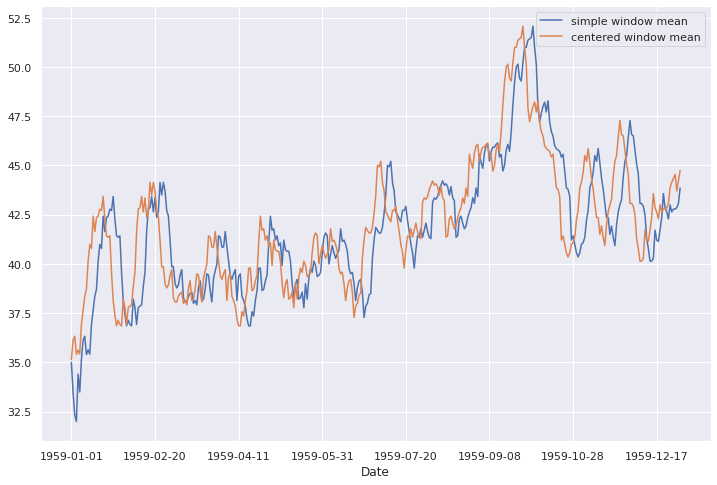

In [ ]:
simple_window = sub_data['Births'].rolling(14, min_periods=0).apply(np.mean)
center_window = sub_data['Births'].rolling(14, center=True, min_periods=0).apply(np.mean)

plt.figure(figsize=(12, 8))
simple_window.plot(label='simple window mean')
center_window.plot(label='centered window mean')
plt.legend()
pass

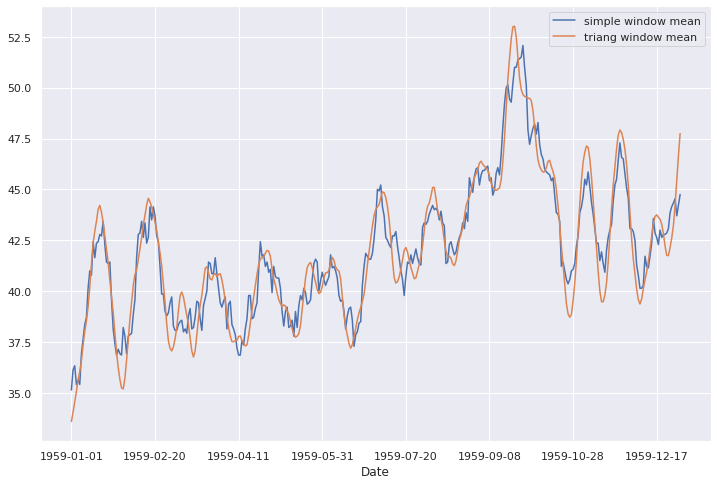

In [ ]:
simple_window = sub_data['Births'].rolling(
    14, center=True, min_periods=0
).apply(np.mean)
center_window = sub_data['Births'].rolling(
    14, center=True, win_type='triang', min_periods=0
).mean()

plt.figure(figsize=(12, 8))
simple_window.plot(label='simple window mean')
center_window.plot(label='triang window mean')
plt.legend()
pass

### Отбираем лаг признаки

#### Прошлые 2 недели

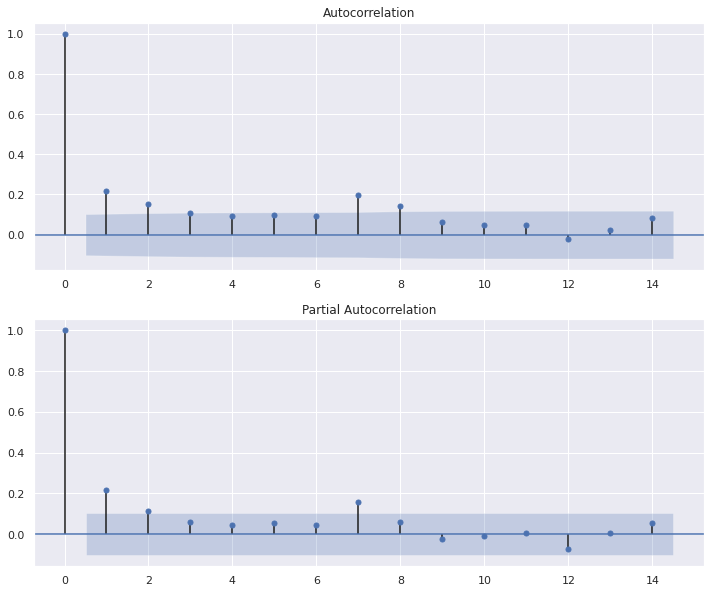

In [ ]:
fig, ax = plt.subplots(2, figsize=(12,10))
ax[0] = plot_acf(data['Births'], ax=ax[0], lags=14)
ax[1] = plot_pacf(data['Births'], ax=ax[1], lags=14)

#### 2 недели месяц назад

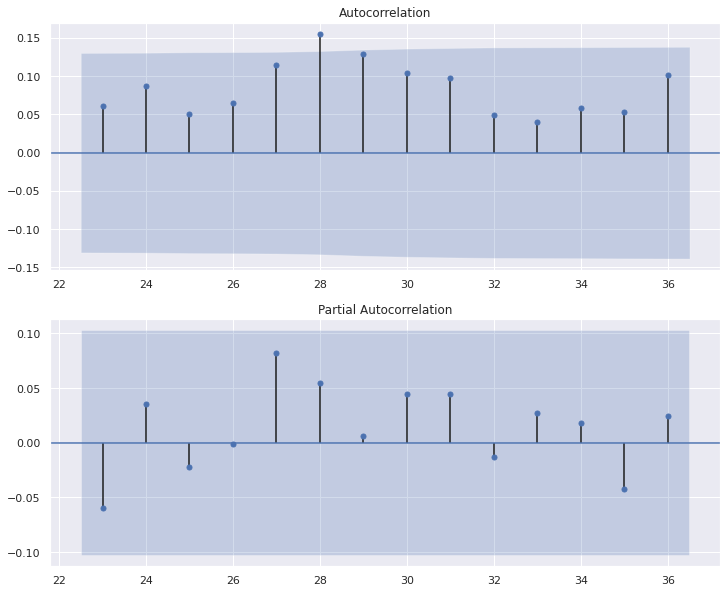

In [ ]:
fig, ax = plt.subplots(2, figsize=(12,10))
ax[0] = plot_acf(data['Births'], ax=ax[0], lags=range(30-7, 30+7))
ax[1] = plot_pacf(data['Births'], ax=ax[1], lags=range(30-7, 30+7))

#### 2 недели полгода назад

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt



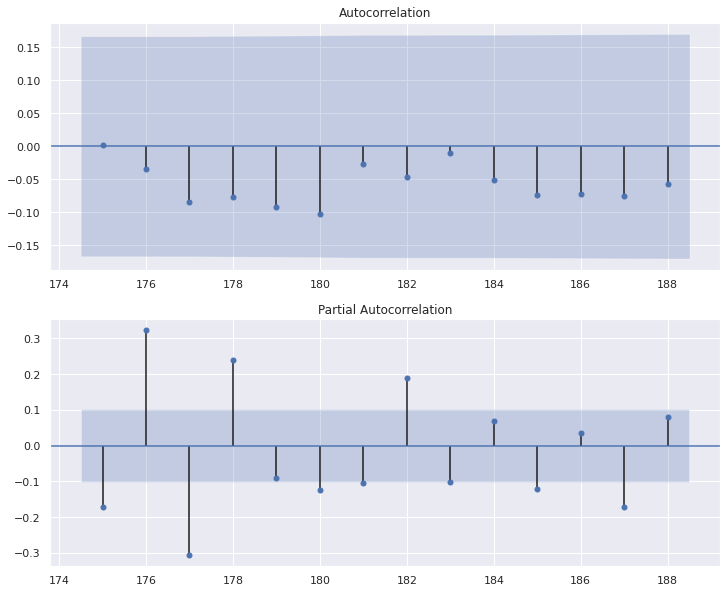

In [ ]:
fig, ax = plt.subplots(2, figsize=(12,10))
ax[0] = plot_acf(data['Births'], ax=ax[0], lags=range(182-7, 182+7))
ax[1] = plot_pacf(data['Births'], ax=ax[1], lags=range(182-7, 182+7))

In [ ]:
x = data[['Date', 'Births']].copy().reset_index(drop=True)
x.head()

,Date,Births
0,1959-01-01,35
1,1959-01-02,32
2,1959-01-03,30
3,1959-01-04,31
4,1959-01-05,44


In [ ]:
x['Births'] = x['Births'].shift(-1)

for i in range(7):
    x[f'Births_shifted_{i+1}'] = x['Births'].shift(i+1)
    
#for i in range(365-3, 365+4):
#    x[f'Births_shifted_{i+1}'] = x['Births'].shift(i+1)
    
x.head()

,Date,Births,Births_shifted_1,Births_shifted_2,Births_shifted_3,Births_shifted_4,Births_shifted_5,Births_shifted_6,Births_shifted_7
0,1959-01-01,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1959-01-02,30.0,32.0,NaN,NaN,NaN,NaN,NaN,NaN
2,1959-01-03,31.0,30.0,32.0,NaN,NaN,NaN,NaN,NaN
3,1959-01-04,44.0,31.0,30.0,32.0,NaN,NaN,NaN,NaN
4,1959-01-05,29.0,44.0,31.0,30.0,32.0,NaN,NaN,NaN


#### Высокая автокорреляция ведет к высокой корреляции

In [ ]:
corr = x.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Births,Births_shifted_1,Births_shifted_2,Births_shifted_3,Births_shifted_4,Births_shifted_5,Births_shifted_6,Births_shifted_7
Births,1.00,0.22,0.15,0.11,0.09,0.09,0.09,0.20
Births_shifted_1,0.22,1.00,0.22,0.15,0.11,0.09,0.09,0.09
Births_shifted_2,0.15,0.22,1.00,0.21,0.15,0.10,0.10,0.10
Births_shifted_3,0.11,0.15,0.21,1.00,0.21,0.14,0.11,0.10
Births_shifted_4,0.09,0.11,0.15,0.21,1.00,0.21,0.14,0.11
Births_shifted_5,0.09,0.09,0.10,0.14,0.21,1.00,0.21,0.15
Births_shifted_6,0.09,0.09,0.10,0.11,0.14,0.21,1.00,0.21
Births_shifted_7,0.20,0.09,0.10,0.10,0.11,0.15,0.21,1.00


#### Используем numba

In [ ]:
import numba as nb


@nb.njit(fastmath=True)
def lin_regression(y: np.ndarray) -> np.ndarray:
    """Получить тренд массива"""
    x = np.arange(len(y))
    m_x = np.mean(x)
    m_y = np.mean(y)
    return np.sum((x - m_x) * (y - m_y)) / np.sum((x - m_x) ** 2)


@nb.njit(fastmath=True)
def max_min_diff(x: np.ndarray) -> np.ndarray:
    x_min = np.min(x)
    x_max = np.max(x)
    return x_max - x_min

In [ ]:
window = 7

x['Births_shifted_1_mean_1_week'] = x['Births_shifted_1'].rolling(window).apply(np.mean)
x['Births_shifted_1_std_1_week'] = x['Births_shifted_1'].rolling(window).apply(np.std)
x['Births_shifted_1_median_1_week'] = x['Births_shifted_1'].rolling(window).apply(np.median)

In [ ]:
x['Births_shifted_1_max_min_1_week'] = x['Births_shifted_1'].rolling(window).apply(
    lambda x: max_min_diff(x.to_numpy())
)
x['Births_shifted_1_trend_1_week'] = x['Births_shifted_1'].rolling(window).apply(
    lambda x: lin_regression(x.to_numpy())
)

In [ ]:
window = 30

x['Births_shifted_1_mean_1_month'] = x['Births_shifted_1'].rolling(window).apply(np.mean)
x['Births_shifted_1_std_1_month'] = x['Births_shifted_1'].rolling(window).apply(np.std)
x['Births_shifted_1_median_1_month'] = x['Births_shifted_1'].rolling(window).apply(np.median)

x['Births_shifted_1_max_min_1_month'] = x['Births_shifted_1'].rolling(window).apply(lambda x: max_min_diff(x.to_numpy()))
x['Births_shifted_1_trend_1_month'] = x['Births_shifted_1'].rolling(window).apply(lambda x: lin_regression(x.to_numpy()))

In [ ]:
corr = x.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Births,Births_shifted_1,Births_shifted_2,Births_shifted_3,Births_shifted_4,Births_shifted_5,Births_shifted_6,Births_shifted_7,Births_shifted_1_mean_1_week,Births_shifted_1_std_1_week,Births_shifted_1_median_1_week,Births_shifted_1_max_min_1_week,Births_shifted_1_trend_1_week,Births_shifted_1_mean_1_month,Births_shifted_1_std_1_month,Births_shifted_1_median_1_month,Births_shifted_1_max_min_1_month,Births_shifted_1_trend_1_month
Births,1.00,0.22,0.15,0.11,0.09,0.09,0.09,0.20,0.26,0.07,0.22,0.07,0.02,0.28,0.05,0.26,0.22,0.03
Births_shifted_1,0.22,1.00,0.22,0.15,0.11,0.09,0.09,0.09,0.48,0.14,0.43,0.16,0.55,0.36,0.14,0.33,0.25,0.27
Births_shifted_2,0.15,0.22,1.00,0.21,0.15,0.10,0.10,0.10,0.51,0.07,0.46,0.11,0.42,0.37,0.13,0.35,0.25,0.29
Births_shifted_3,0.11,0.15,0.21,1.00,0.21,0.14,0.11,0.10,0.53,0.10,0.48,0.13,0.22,0.37,0.14,0.33,0.27,0.29
Births_shifted_4,0.09,0.11,0.15,0.21,1.00,0.21,0.14,0.11,0.53,0.08,0.46,0.09,-0.00,0.37,0.14,0.33,0.27,0.28
Births_shifted_5,0.09,0.09,0.10,0.14,0.21,1.00,0.21,0.15,0.52,0.06,0.44,0.07,-0.23,0.37,0.16,0.33,0.30,0.24
Births_shifted_6,0.09,0.09,0.10,0.11,0.14,0.21,1.00,0.21,0.52,0.06,0.46,0.10,-0.42,0.38,0.15,0.34,0.28,0.21
Births_shifted_7,0.20,0.09,0.10,0.10,0.11,0.15,0.21,1.00,0.49,0.04,0.44,0.07,-0.55,0.38,0.12,0.34,0.25,0.19
Births_shifted_1_mean_1_week,0.26,0.48,0.51,0.53,0.53,0.52,0.52,0.49,1.00,0.16,0.89,0.21,-0.01,0.72,0.27,0.65,0.51,0.49
Births_shifted_1_std_1_week,0.07,0.14,0.07,0.10,0.08,0.06,0.06,0.04,0.16,1.00,0.04,0.96,0.07,-0.08,0.47,-0.21,0.22,0.26


In [ ]:
x.head()

,Date,Births,Births_shifted_1,Births_shifted_2,Births_shifted_3,Births_shifted_4,Births_shifted_5,Births_shifted_6,Births_shifted_7,Births_shifted_1_mean_1_week,Births_shifted_1_std_1_week,Births_shifted_1_median_1_week,Births_shifted_1_max_min_1_week,Births_shifted_1_trend_1_week,Births_shifted_1_mean_1_month,Births_shifted_1_std_1_month,Births_shifted_1_median_1_month,Births_shifted_1_max_min_1_month,Births_shifted_1_trend_1_month
0,1959-01-01,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1959-01-02,30.0,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1959-01-03,31.0,30.0,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1959-01-04,44.0,31.0,30.0,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1959-01-05,29.0,44.0,31.0,30.0,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Разделение на трейн и тест 

In [ ]:
backup = x.copy()
x = x.dropna()
y = x['Births']
del x['Births']

In [ ]:
split_train_size = 0.7
split_val_size = 0.85

dates = pd.to_datetime(x['Date'])
train_quantile = dates.quantile(split_train_size)
val_quantile = dates.quantile(split_val_size)

x_train = x[dates < train_quantile]
y_train = y[dates < train_quantile]

x_val = x[(dates >= train_quantile) & (dates < val_quantile)]
y_val = y[(dates >= train_quantile) & (dates < val_quantile)]

x_test = x[dates > val_quantile]
y_test = y[dates > val_quantile]

print(f'Train      from {x_train.Date.min()} to {x_train.Date.max()}')
print(f'Validation from {x_val.Date.min()} to {x_val.Date.max()}')
print(f'Test       from {x_test.Date.min()} to {x_test.Date.max()}')

del x_train['Date']
del x_val['Date']
del x_test['Date']

Train      from 1959-01-31 to 1959-09-21
Validation from 1959-09-22 to 1959-11-10
Test       from 1959-11-11 to 1959-12-30


### Моделируем

In [ ]:
import lightgbm as lgb

filt = [col for col in x_train if '_1_' not in col]
train_mat = lgb.Dataset(x_train[filt], label=y_train)
val_mat = lgb.Dataset(x_val[filt], label=y_val)

params = {
    'metric': 'mse', 
    'objective': 'mse', 
    'feature_fraction': 1,
    'learning_rate': 0.01,
    'force_row_wise': True
}

model = lgb.train(
    params,
    train_mat,
    valid_sets=[train_mat, val_mat],
    num_boost_round=1000,
    verbose_eval=50,
    early_stopping_rounds=100
)

only_lag_mse = mean_squared_error(y_test, model.predict(x_test[filt]))

Training until validation scores don't improve for 100 rounds.
[50]	training's l2: 46.0752	valid_1's l2: 66.6545
[100]	training's l2: 42.1366	valid_1's l2: 63.9248
[150]	training's l2: 39.2926	valid_1's l2: 62.1849
[200]	training's l2: 36.4858	valid_1's l2: 61.787
[250]	training's l2: 34.1631	valid_1's l2: 61.5868
[300]	training's l2: 31.8758	valid_1's l2: 60.4336
[350]	training's l2: 29.8492	valid_1's l2: 60.0582
[400]	training's l2: 28.0891	valid_1's l2: 59.7897
[450]	training's l2: 26.5441	valid_1's l2: 59.4494
[500]	training's l2: 25.277	valid_1's l2: 59.218
[550]	training's l2: 24.005	valid_1's l2: 59.1062
[600]	training's l2: 22.8109	valid_1's l2: 59.4543
[650]	training's l2: 21.7798	valid_1's l2: 60.0829
Early stopping, best iteration is:
[564]	training's l2: 23.6189	valid_1's l2: 58.9762


In [ ]:
train_mat = lgb.Dataset(x_train, label=y_train)
val_mat = lgb.Dataset(x_val, label=y_val)

params = {
    'metric': 'mse', 
    'objective': 'mse', 
    'feature_fraction': 1,
    'learning_rate': 0.01,
    'force_row_wise': True
}

model = lgb.train(
    params,
    train_mat,
    valid_sets=[train_mat, val_mat],
    num_boost_round=1000,
    verbose_eval=50,
    early_stopping_rounds=100
)

all_mse = mean_squared_error(y_test, model.predict(x_test))
feats_importance = model.feature_importance()

Training until validation scores don't improve for 100 rounds.
[50]	training's l2: 43.0634	valid_1's l2: 59.6369
[100]	training's l2: 38.0831	valid_1's l2: 55.3589
[150]	training's l2: 33.9413	valid_1's l2: 53.2292
[200]	training's l2: 30.5557	valid_1's l2: 51.9978
[250]	training's l2: 27.6265	valid_1's l2: 51.1857
[300]	training's l2: 25.2129	valid_1's l2: 50.4262
[350]	training's l2: 23.144	valid_1's l2: 50.7262
[400]	training's l2: 20.9837	valid_1's l2: 51.0823
Early stopping, best iteration is:
[304]	training's l2: 25.0432	valid_1's l2: 50.3865


In [ ]:
good_feats = list(corr[corr['Births'] > 0.5].index.values)
good_feats.remove('Births')

train_mat = lgb.Dataset(x_train[good_feats], label=y_train)
val_mat = lgb.Dataset(x_val[good_feats], label=y_val)

params = {
    'metric': 'mse', 
    'objective': 'mse', 
    'feature_fraction': 1,
    'learning_rate': 0.01,
    'force_row_wise': True
}

model = lgb.train(
    params,
    train_mat,
    valid_sets=[train_mat, val_mat],
    num_boost_round=1000,
    verbose_eval=50,
    early_stopping_rounds=100
)

only_good_mse = mean_squared_error(y_test, model.predict(x_test[good_feats]))

Training until validation scores don't improve for 100 rounds.
[50]	training's l2: 1758.68	valid_1's l2: 1420.5
[100]	training's l2: 1758.68	valid_1's l2: 1420.5
Early stopping, best iteration is:
[1]	training's l2: 1758.68	valid_1's l2: 1420.5


In [ ]:
print('All features MSE:      ', round(all_mse, 5))
print('Only lag features MSE: ', round(only_lag_mse, 5))
print('Only good features MSE:', round(only_good_mse, 5))

All features MSE:       47.83595
Only lag features MSE:  47.71964
Only good features MSE: 45.59811


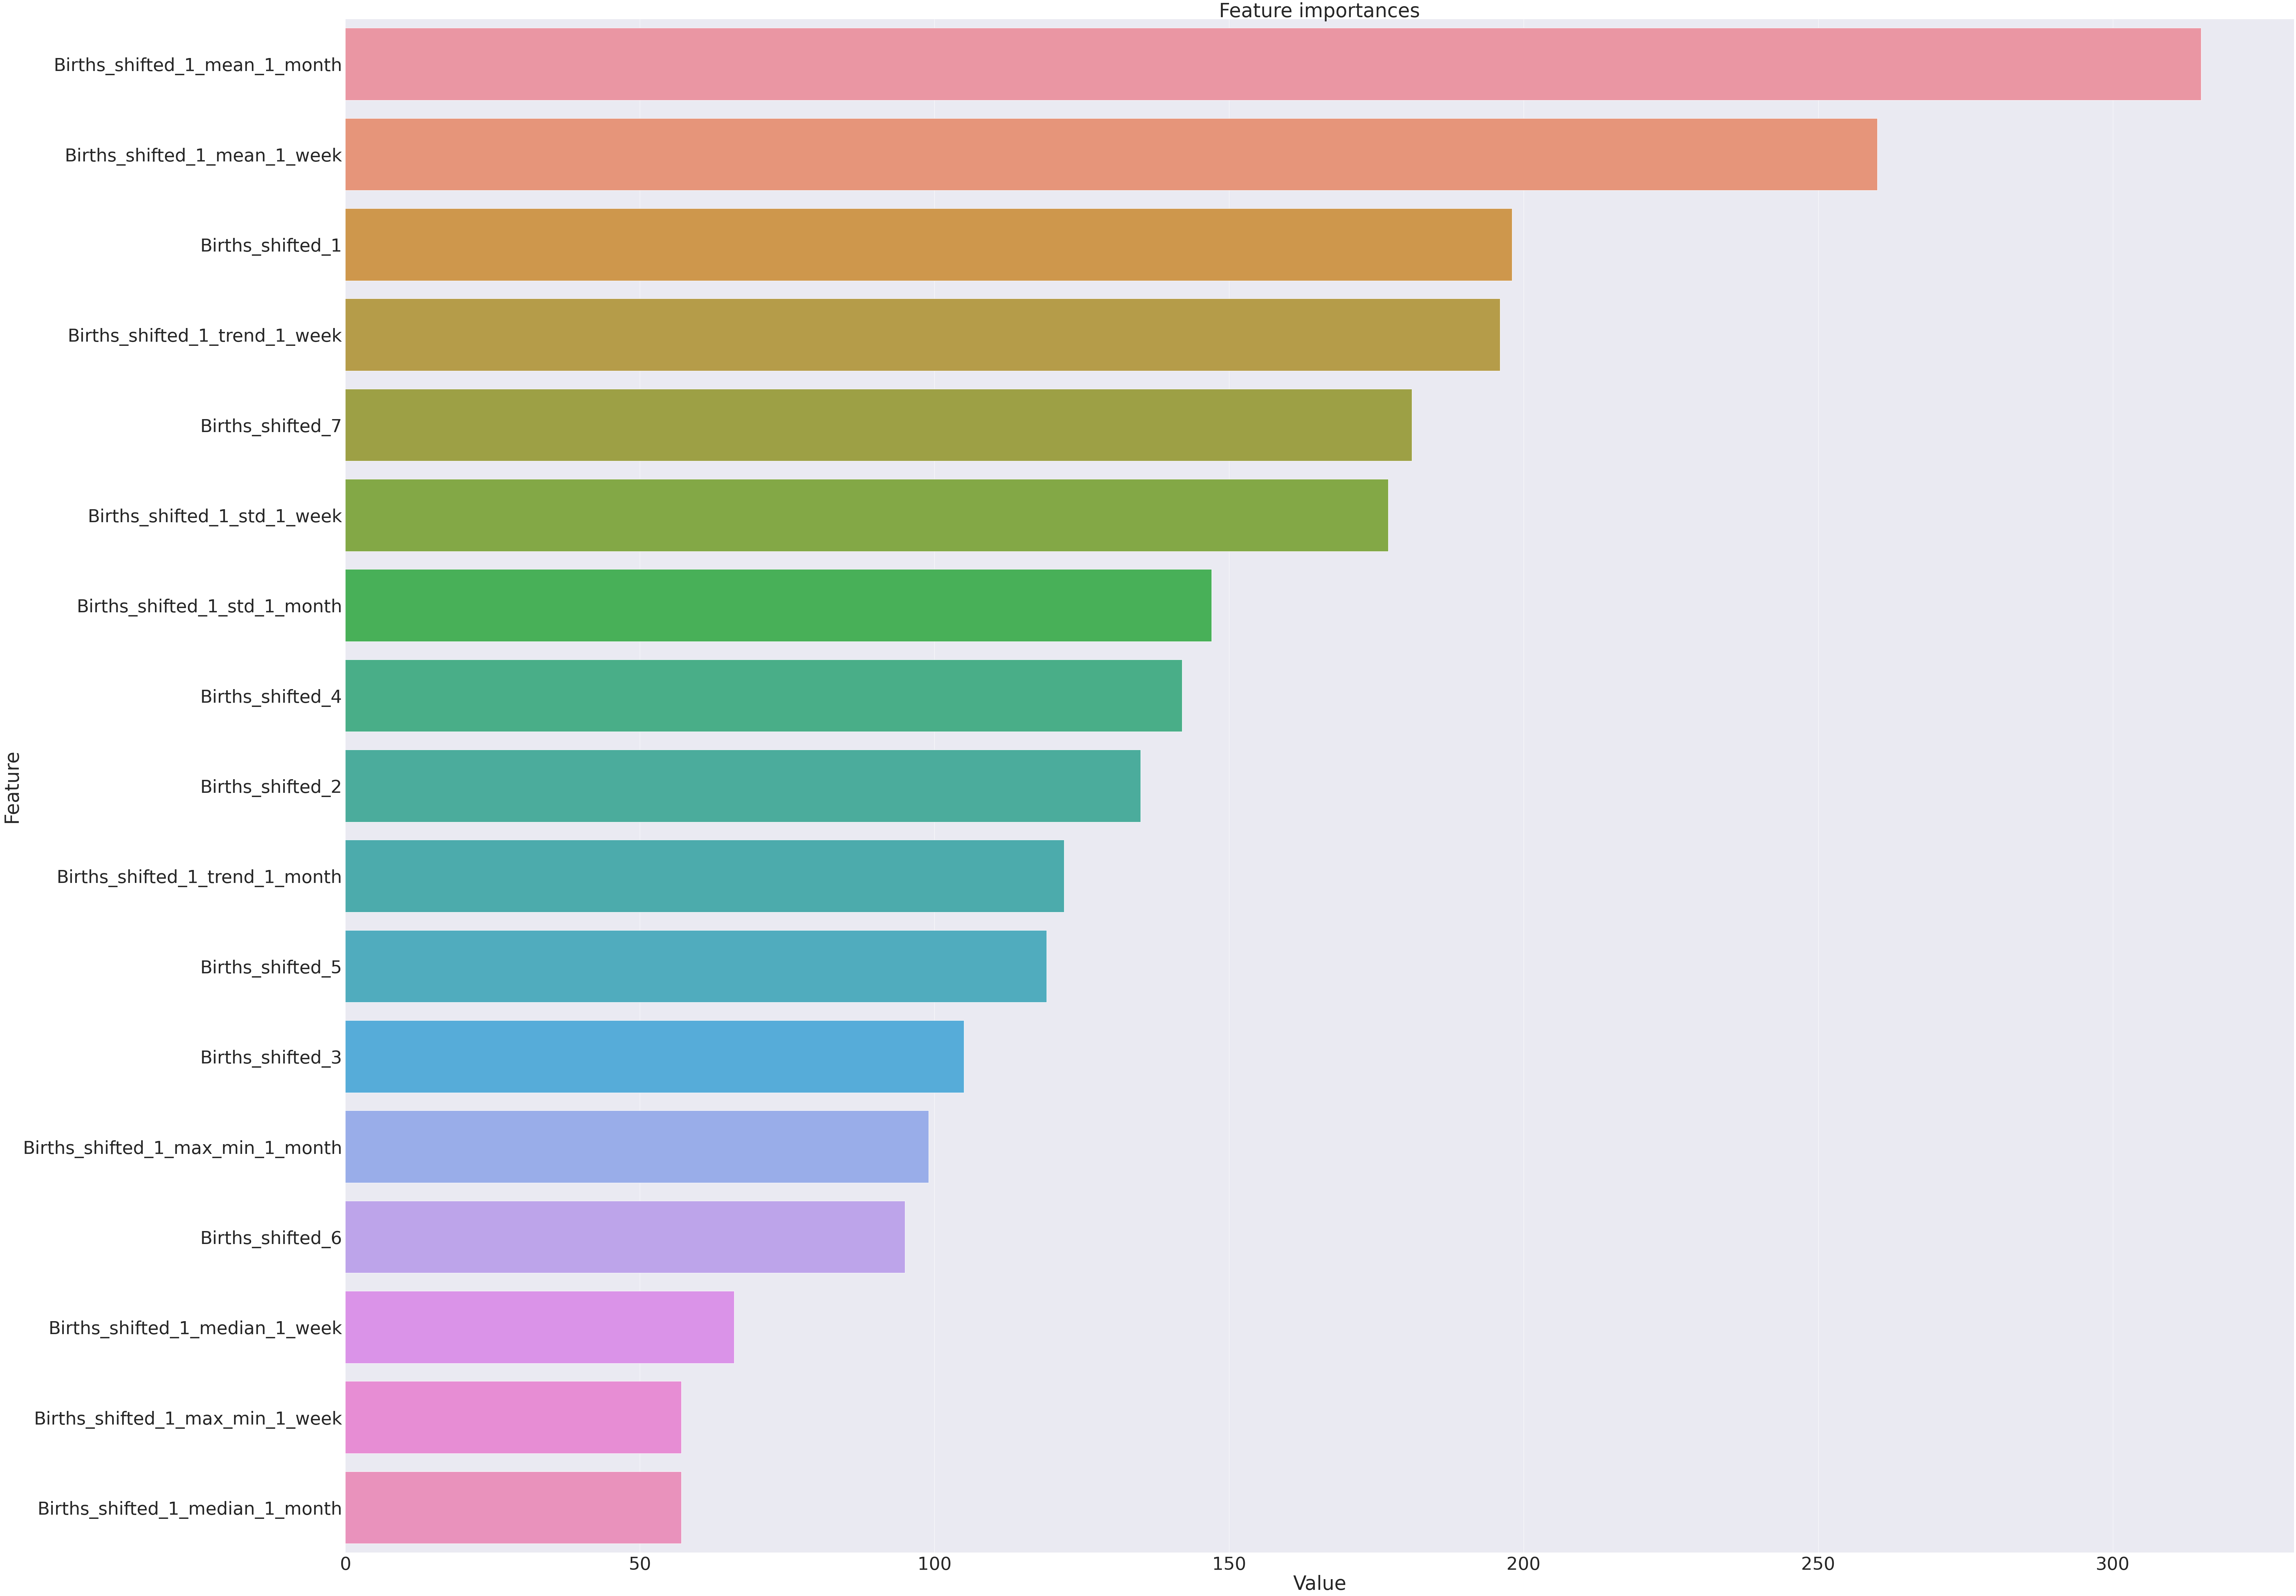

In [ ]:
def plot_importance(importances) -> None:
    feature_imp = pd.DataFrame({'Value': importances, 'Feature': x_train.columns})

    plt.figure(figsize=(100, 70))
    sns.set(font_scale=5)
    sns_plot = sns.barplot(x='Value', y='Feature', data=feature_imp.sort_values('Value', ascending=False))
    plt.title(f'Feature importances')
    plt.tight_layout()
    sns_plot = sns_plot.get_figure()
    
plot_importance(feats_importance)

In [ ]:
good_feats = x_train.columns[np.argsort(feats_importance)[-25:]]

train_mat = lgb.Dataset(x_train[good_feats], label=y_train)
val_mat = lgb.Dataset(x_val[good_feats], label=y_val)

params = {
    'metric': 'mse', 
    'objective': 'mse', 
    'feature_fraction': 1,
    'learning_rate': 0.01,
    'force_row_wise': True
}

model = lgb.train(
    params,
    train_mat,
    valid_sets=[train_mat, val_mat],
    num_boost_round=1000,
    verbose_eval=50,
    early_stopping_rounds=100
)

only_good_by_imp_mse = mean_squared_error(y_test, model.predict(x_test[good_feats]))

Training until validation scores don't improve for 100 rounds.
[50]	training's l2: 43.0634	valid_1's l2: 59.6369
[100]	training's l2: 38.0831	valid_1's l2: 55.3589
[150]	training's l2: 33.9413	valid_1's l2: 53.2296
[200]	training's l2: 30.5557	valid_1's l2: 51.997
[250]	training's l2: 27.6265	valid_1's l2: 51.1844
[300]	training's l2: 25.2129	valid_1's l2: 50.4238
[350]	training's l2: 23.144	valid_1's l2: 50.7233
[400]	training's l2: 20.9837	valid_1's l2: 51.08
Early stopping, best iteration is:
[304]	training's l2: 25.0432	valid_1's l2: 50.384


In [ ]:
print('All features MSE:             ', round(all_mse, 5))
print('Only lag features MSE:        ', round(only_lag_mse, 5))
print('Only good features MSE:       ', round(only_good_mse, 5))
print('Only good features by imp MSE:', round(only_good_by_imp_mse, 5))

All features MSE:              47.83595
Only lag features MSE:         47.71964
Only good features MSE:        45.59811
Only good features by imp MSE: 47.83595


In [ ]:
linreg = LinearRegression()

linreg.fit(x_train, y_train)

print('LGBM best mse:', round(only_good_by_imp_mse, 5))
print('Linreg mse:   ', round(mean_squared_error(y_test, linreg.predict(x_test)), 5))

LGBM best mse: 47.83595
Linreg mse:    44.92226


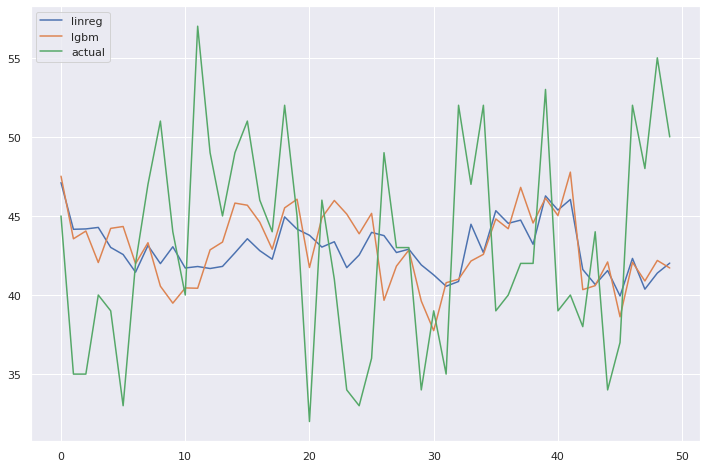

In [ ]:
sns.set(font_scale=1)
size = 365
plt.figure(figsize=(12, 8))
plt.plot(linreg.predict(x_test)[:size], label='linreg')
plt.plot(model.predict(x_test[good_feats])[:size], label='lgbm')
plt.plot(y_test.reset_index(drop=True)[:size], label='actual')
plt.legend()
plt.show()

In [ ]:
x = backup.copy()
x['Births'] = x['Births'].shift(-30)
x = x.dropna()
y = x['Births']
del x['Births']

split_train_size = 0.7
split_val_size = 0.85

dates = pd.to_datetime(x['Date'])
train_quantile = dates.quantile(split_train_size)
val_quantile = dates.quantile(split_val_size)

x_train = x[dates < train_quantile]
y_train = y[dates < train_quantile]

x_val = x[(dates >= train_quantile) & (dates < val_quantile)]
y_val = y[(dates >= train_quantile) & (dates < val_quantile)]

x_test = x[dates > val_quantile]
y_test = y[dates > val_quantile]

print(f'Train      from {x_train.Date.min()} to {x_train.Date.max()}')
print(f'Validation from {x_val.Date.min()} to {x_val.Date.max()}')
print(f'Test       from {x_test.Date.min()} to {x_test.Date.max()}')

del x_train['Date']
del x_val['Date']
del x_test['Date']

Train      from 1959-01-31 to 1959-08-31
Validation from 1959-09-01 to 1959-10-15
Test       from 1959-10-16 to 1959-11-30


#### Optuna

In [ ]:
!pip install optuna

In [ ]:
import optuna.integration.lightgbm as lgboptuna


train_mat = lgb.Dataset(x_train, label=y_train)
val_mat = lgb.Dataset(x_val, label=y_val)

params = {
    'metric': 'mse', 
    'objective': 'mse', 
    'force_row_wise': True,
    'learning_rate': 0.01
}

tuner = lgboptuna.LightGBMTuner(
    params=params,
    train_set=train_mat,
    valid_sets=[train_mat, val_mat],
    num_boost_round=1000,
    verbose_eval=50,
    early_stopping_rounds=100,
    time_budget=600
)

tuner.run()

model = tuner.get_best_booster()

all_mse = mean_squared_error(y_test, model.predict(x_test))
feats_importance = model.feature_importance()

[I 2021-12-25 15:37:53,594] A new study created in memory with name: no-name-eaabff41-0e10-435a-94e6-d4d981cc6cc1
feature_fraction, val_score: 38.734870:  14%|#4        | 1/7 [00:00<00:00,  8.44it/s]

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 44.893	valid_1's l2: 38.8339
[100]	valid_0's l2: 39.2053	valid_1's l2: 41.4655
Early stopping, best iteration is:
[43]	valid_0's l2: 45.8776	valid_1's l2: 38.7349
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 45.8716	valid_1's l2: 39.1553
[100]	valid_0's l2: 40.1882	valid_1's l2: 39.0768


feature_fraction, val_score: 38.608166:  43%|####2     | 3/7 [00:00<00:00,  6.48it/s]

[150]	valid_0's l2: 36.1107	valid_1's l2: 40.9039
Early stopping, best iteration is:
[75]	valid_0's l2: 42.7974	valid_1's l2: 38.6082
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 44.954	valid_1's l2: 38.7928
[100]	valid_0's l2: 39.4592	valid_1's l2: 41.2257
Early stopping, best iteration is:
[44]	valid_0's l2: 45.7811	valid_1's l2: 38.7303


feature_fraction, val_score: 38.608166:  57%|#####7    | 4/7 [00:00<00:00,  6.65it/s]

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 45.0137	valid_1's l2: 38.829
[100]	valid_0's l2: 39.4489	valid_1's l2: 41.2237
Early stopping, best iteration is:
[43]	valid_0's l2: 45.9683	valid_1's l2: 38.7264
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 45.1468	valid_1's l2: 38.9246
[100]	valid_0's l2: 39.6157	valid_1's l2: 40.4474


feature_fraction, val_score: 38.608166:  71%|#######1  | 5/7 [00:00<00:00,  6.13it/s]

[150]	valid_0's l2: 35.3974	valid_1's l2: 43.6247
Early stopping, best iteration is:
[53]	valid_0's l2: 44.7491	valid_1's l2: 38.891


feature_fraction, val_score: 38.608166:  86%|########5 | 6/7 [00:01<00:00,  4.23it/s]

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 44.9608	valid_1's l2: 38.6354
[100]	valid_0's l2: 39.3424	valid_1's l2: 40.9828
Early stopping, best iteration is:
[49]	valid_0's l2: 45.0951	valid_1's l2: 38.634
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 44.9815	valid_1's l2: 38.7214


feature_fraction, val_score: 38.608166: 100%|##########| 7/7 [00:01<00:00,  5.15it/s]


[100]	valid_0's l2: 39.3901	valid_1's l2: 41.4343
Early stopping, best iteration is:
[42]	valid_0's l2: 46.1523	valid_1's l2: 38.6906


num_leaves, val_score: 38.608166:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 45.8716	valid_1's l2: 39.1553


num_leaves, val_score: 38.608166:   5%|5         | 1/20 [00:00<00:07,  2.48it/s]

[100]	valid_0's l2: 40.1882	valid_1's l2: 39.0768
[150]	valid_0's l2: 36.1107	valid_1's l2: 40.9039
Early stopping, best iteration is:
[75]	valid_0's l2: 42.7974	valid_1's l2: 38.6082
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 45.8716	valid_1's l2: 39.1553
[100]	valid_0's l2: 40.1882	valid_1's l2: 39.0768
[150]	valid_0's l2: 36.1107	valid_1's l2: 40.9039


num_leaves, val_score: 38.608166:  15%|#5        | 3/20 [00:00<00:03,  4.74it/s]

Early stopping, best iteration is:
[75]	valid_0's l2: 42.7974	valid_1's l2: 38.6082
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 45.8716	valid_1's l2: 39.1553
[100]	valid_0's l2: 40.1882	valid_1's l2: 39.0768
[150]	valid_0's l2: 36.1107	valid_1's l2: 40.9039
Early stopping, best iteration is:
[75]	valid_0's l2: 42.7974	valid_1's l2: 38.6082


num_leaves, val_score: 38.608166:  20%|##        | 4/20 [00:00<00:03,  5.07it/s]

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 45.8716	valid_1's l2: 39.1553
[100]	valid_0's l2: 40.1882	valid_1's l2: 39.0768
[150]	valid_0's l2: 36.1107	valid_1's l2: 40.9039
Early stopping, best iteration is:
[75]	valid_0's l2: 42.7974	valid_1's l2: 38.6082
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 45.8716	valid_1's l2: 39.1553

num_leaves, val_score: 38.608166:  25%|##5       | 5/20 [00:01<00:02,  5.24it/s]


[100]	valid_0's l2: 40.1882	valid_1's l2: 39.0768
[150]	valid_0's l2: 36.1107	valid_1's l2: 40.9039
Early stopping, best iteration is:
[75]	valid_0's l2: 42.7974	valid_1's l2: 38.6082
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 45.8716	valid_1's l2: 39.1553


num_leaves, val_score: 38.608166:  30%|###       | 6/20 [00:01<00:02,  5.40it/s]

[100]	valid_0's l2: 40.1882	valid_1's l2: 39.0768
[150]	valid_0's l2: 36.1107	valid_1's l2: 40.9039
Early stopping, best iteration is:
[75]	valid_0's l2: 42.7974	valid_1's l2: 38.6082
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 45.8716	valid_1's l2: 39.1553
[100]	valid_0's l2: 40.1882	valid_1's l2: 39.0768


num_leaves, val_score: 38.608166:  40%|####      | 8/20 [00:01<00:02,  5.74it/s]

[150]	valid_0's l2: 36.1107	valid_1's l2: 40.9039
Early stopping, best iteration is:
[75]	valid_0's l2: 42.7974	valid_1's l2: 38.6082
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 45.8716	valid_1's l2: 39.1553
[100]	valid_0's l2: 40.1882	valid_1's l2: 39.0768
[150]	valid_0's l2: 36.1107	valid_1's l2: 40.9039
Early stopping, best iteration is:
[75]	valid_0's l2: 42.7974	valid_1's l2: 38.6082


num_leaves, val_score: 38.608166:  45%|####5     | 9/20 [00:01<00:01,  6.00it/s]

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 45.8716	valid_1's l2: 39.1553
[100]	valid_0's l2: 40.1882	valid_1's l2: 39.0768
[150]	valid_0's l2: 36.1107	valid_1's l2: 40.9039
Early stopping, best iteration is:
[75]	valid_0's l2: 42.7974	valid_1's l2: 38.6082
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 45.8716	valid_1's l2: 39.1553


num_leaves, val_score: 38.608166:  50%|#####     | 10/20 [00:01<00:01,  6.11it/s]

[100]	valid_0's l2: 40.1882	valid_1's l2: 39.0768
[150]	valid_0's l2: 36.1107	valid_1's l2: 40.9039
Early stopping, best iteration is:
[75]	valid_0's l2: 42.7974	valid_1's l2: 38.6082
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 45.8716	valid_1's l2: 39.1553
[100]	valid_0's l2: 40.1882	valid_1's l2: 39.0768
[150]	valid_0's l2: 36.1107	valid_1's l2: 40.9039


num_leaves, val_score: 38.608166:  60%|######    | 12/20 [00:02<00:01,  6.24it/s]

Early stopping, best iteration is:
[75]	valid_0's l2: 42.7974	valid_1's l2: 38.6082
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 45.8716	valid_1's l2: 39.1553
[100]	valid_0's l2: 40.1882	valid_1's l2: 39.0768
[150]	valid_0's l2: 36.1107	valid_1's l2: 40.9039
Early stopping, best iteration is:
[75]	valid_0's l2: 42.7974	valid_1's l2: 38.6082
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 45.8716	valid_1's l2: 39.1553
[100]	valid_0's l2: 40.1882	valid_1's l2: 39.0768


num_leaves, val_score: 38.608166:  65%|######5   | 13/20 [00:02<00:02,  3.28it/s]

[150]	valid_0's l2: 36.1107	valid_1's l2: 40.9039
Early stopping, best iteration is:
[75]	valid_0's l2: 42.7974	valid_1's l2: 38.6082
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 45.8716	valid_1's l2: 39.1553
[100]	valid_0's l2: 40.1882	valid_1's l2: 39.0768


num_leaves, val_score: 38.608166:  70%|#######   | 14/20 [00:03<00:02,  2.13it/s]

[150]	valid_0's l2: 36.1107	valid_1's l2: 40.9039
Early stopping, best iteration is:
[75]	valid_0's l2: 42.7974	valid_1's l2: 38.6082
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 45.8716	valid_1's l2: 39.1553
[100]	valid_0's l2: 40.1882	valid_1's l2: 39.0768


num_leaves, val_score: 38.608166:  75%|#######5  | 15/20 [00:04<00:03,  1.41it/s]

[150]	valid_0's l2: 36.1107	valid_1's l2: 40.9039
Early stopping, best iteration is:
[75]	valid_0's l2: 42.7974	valid_1's l2: 38.6082
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 45.8716	valid_1's l2: 39.1553


num_leaves, val_score: 38.608166:  75%|#######5  | 15/20 [00:05<00:03,  1.41it/s]

[100]	valid_0's l2: 40.1882	valid_1's l2: 39.0768
[150]	valid_0's l2: 36.1107	valid_1's l2: 40.9039
Early stopping, best iteration is:
[75]	valid_0's l2: 42.7974	valid_1's l2: 38.6082


num_leaves, val_score: 38.608166:  80%|########  | 16/20 [00:05<00:02,  1.50it/s]

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 45.8716	valid_1's l2: 39.1553
[100]	valid_0's l2: 40.1882	valid_1's l2: 39.0768


num_leaves, val_score: 38.608166:  85%|########5 | 17/20 [00:07<00:02,  1.07it/s]

[150]	valid_0's l2: 36.1107	valid_1's l2: 40.9039
Early stopping, best iteration is:
[75]	valid_0's l2: 42.7974	valid_1's l2: 38.6082
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 45.8716	valid_1's l2: 39.1553
[100]	valid_0's l2: 40.1882	valid_1's l2: 39.0768


num_leaves, val_score: 38.608166:  90%|######### | 18/20 [00:09<00:02,  1.49s/it]

[150]	valid_0's l2: 36.1107	valid_1's l2: 40.9039
Early stopping, best iteration is:
[75]	valid_0's l2: 42.7974	valid_1's l2: 38.6082
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 48.2375	valid_1's l2: 38.9408
[100]	valid_0's l2: 44.3394	valid_1's l2: 38.4484
[150]	valid_0's l2: 41.5527	valid_1's l2: 40.0045


num_leaves, val_score: 38.263747:  95%|#########5| 19/20 [00:10<00:01,  1.08s/it]

Early stopping, best iteration is:
[78]	valid_0's l2: 45.8945	valid_1's l2: 38.2637
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 45.8716	valid_1's l2: 39.1553
[100]	valid_0's l2: 40.1882	valid_1's l2: 39.0768
[150]	valid_0's l2: 36.1107	valid_1's l2: 40.9039


num_leaves, val_score: 38.263747: 100%|##########| 20/20 [00:10<00:00,  1.91it/s]


Early stopping, best iteration is:
[75]	valid_0's l2: 42.7974	valid_1's l2: 38.6082


bagging, val_score: 38.263747:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 48.4789	valid_1's l2: 39.5171
[100]	valid_0's l2: 44.443	valid_1's l2: 38.6536


bagging, val_score: 38.263747:  10%|#         | 1/10 [00:00<00:01,  4.92it/s]

[150]	valid_0's l2: 41.7712	valid_1's l2: 39.2626
[200]	valid_0's l2: 39.5715	valid_1's l2: 40.7728
Early stopping, best iteration is:
[106]	valid_0's l2: 44.1089	valid_1's l2: 38.6222


bagging, val_score: 38.263747:  20%|##        | 2/10 [00:00<00:01,  4.03it/s]

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 48.1912	valid_1's l2: 39.3561
[100]	valid_0's l2: 44.3366	valid_1's l2: 39.0914
[150]	valid_0's l2: 41.4982	valid_1's l2: 40.1404
Early stopping, best iteration is:
[78]	valid_0's l2: 45.8473	valid_1's l2: 38.8091
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 48.448	valid_1's l2: 39.6343
[100]	valid_0's l2: 44.3926	valid_1's l2: 39.1454


bagging, val_score: 38.263747:  30%|###       | 3/10 [00:00<00:01,  4.62it/s]

[150]	valid_0's l2: 41.576	valid_1's l2: 39.645
Early stopping, best iteration is:
[75]	valid_0's l2: 46.2082	valid_1's l2: 38.7727
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 49.0393	valid_1's l2: 39.8134
[100]	valid_0's l2: 44.8457	valid_1's l2: 38.8156
[150]	valid_0's l2: 42.4263	valid_1's l2: 38.9157


bagging, val_score: 38.263747:  50%|#####     | 5/10 [00:00<00:00,  5.69it/s]

[200]	valid_0's l2: 40.4505	valid_1's l2: 39.8884
Early stopping, best iteration is:
[106]	valid_0's l2: 44.4813	valid_1's l2: 38.6909
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 48.2579	valid_1's l2: 39.3633
[100]	valid_0's l2: 44.3314	valid_1's l2: 38.5439
[150]	valid_0's l2: 41.6243	valid_1's l2: 39.6777
Early stopping, best iteration is:
[78]	valid_0's l2: 45.8317	valid_1's l2: 38.4138


bagging, val_score: 38.263747:  60%|######    | 6/10 [00:01<00:00,  5.48it/s]

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 48.4111	valid_1's l2: 39.4564
[100]	valid_0's l2: 44.1799	valid_1's l2: 39.1277
[150]	valid_0's l2: 41.4849	valid_1's l2: 40.2217
Early stopping, best iteration is:
[75]	valid_0's l2: 46.0767	valid_1's l2: 38.7074
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 49.0627	valid_1's l2: 39.9991
[100]	valid_0's l2: 44.9614	valid_1's l2: 38.9157


bagging, val_score: 38.263747:  70%|#######   | 7/10 [00:01<00:00,  5.55it/s]

[150]	valid_0's l2: 42.4375	valid_1's l2: 38.8962
[200]	valid_0's l2: 40.2692	valid_1's l2: 39.8961
Early stopping, best iteration is:
[138]	valid_0's l2: 42.9175	valid_1's l2: 38.656
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 48.5643	valid_1's l2: 39.6645
[100]	valid_0's l2: 44.4391	valid_1's l2: 38.7564
[150]	valid_0's l2: 42.0324	valid_1's l2: 39.2139


bagging, val_score: 38.263747:  80%|########  | 8/10 [00:01<00:00,  5.79it/s]

Early stopping, best iteration is:
[95]	valid_0's l2: 44.7688	valid_1's l2: 38.6664


bagging, val_score: 38.263747:  90%|######### | 9/10 [00:02<00:00,  3.41it/s]

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 48.4723	valid_1's l2: 39.5202
[100]	valid_0's l2: 44.4746	valid_1's l2: 38.4793
[150]	valid_0's l2: 41.7345	valid_1's l2: 39.1279
[200]	valid_0's l2: 39.5719	valid_1's l2: 40.3058
Early stopping, best iteration is:
[103]	valid_0's l2: 44.2863	valid_1's l2: 38.4638


bagging, val_score: 38.263747: 100%|##########| 10/10 [00:02<00:00,  4.33it/s]


Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 48.5458	valid_1's l2: 39.4866
[100]	valid_0's l2: 44.4174	valid_1's l2: 38.5587
[150]	valid_0's l2: 41.9473	valid_1's l2: 38.9145
Early stopping, best iteration is:
[98]	valid_0's l2: 44.5829	valid_1's l2: 38.4388


feature_fraction_stage2, val_score: 38.263747:  33%|###3      | 1/3 [00:00<00:00,  7.72it/s]

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 47.7336	valid_1's l2: 38.9691
[100]	valid_0's l2: 43.9296	valid_1's l2: 40.1267
[150]	valid_0's l2: 41.1851	valid_1's l2: 41.8462
Early stopping, best iteration is:
[56]	valid_0's l2: 47.1623	valid_1's l2: 38.895
Training until validation scores don't improve for 100 rounds.

feature_fraction_stage2, val_score: 38.263747:  67%|######6   | 2/3 [00:00<00:00,  4.32it/s]


[50]	valid_0's l2: 47.7819	valid_1's l2: 38.8011
[100]	valid_0's l2: 43.9967	valid_1's l2: 39.5503
[150]	valid_0's l2: 41.2825	valid_1's l2: 41.683
Early stopping, best iteration is:
[66]	valid_0's l2: 46.3521	valid_1's l2: 38.6304


feature_fraction_stage2, val_score: 38.263747: 100%|##########| 3/3 [00:00<00:00,  4.11it/s]


Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 47.7819	valid_1's l2: 38.8011
[100]	valid_0's l2: 43.9967	valid_1's l2: 39.5503
[150]	valid_0's l2: 41.2825	valid_1's l2: 41.683
Early stopping, best iteration is:
[66]	valid_0's l2: 46.3521	valid_1's l2: 38.6304


regularization_factors, val_score: 38.263747:   5%|5         | 1/20 [00:00<00:04,  4.72it/s]

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 48.2376	valid_1's l2: 38.9408
[100]	valid_0's l2: 44.3394	valid_1's l2: 38.4484
[150]	valid_0's l2: 41.5527	valid_1's l2: 40.0045
Early stopping, best iteration is:
[78]	valid_0's l2: 45.8945	valid_1's l2: 38.2638


regularization_factors, val_score: 38.263747:  10%|#         | 2/20 [00:00<00:04,  4.19it/s][I 2021-12-25 15:38:09,061] Trial 41 finished with value: 38.26374700880247 and parameters: {'lambda_l1': 2.7703914382472984e-07, 'lambda_l2': 4.83756778321679e-06}. Best is trial 41 with value: 38.26374700880247.


Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 48.2375	valid_1's l2: 38.9408
[100]	valid_0's l2: 44.3394	valid_1's l2: 38.4484
[150]	valid_0's l2: 41.5527	valid_1's l2: 40.0045
Early stopping, best iteration is:
[78]	valid_0's l2: 45.8945	valid_1's l2: 38.2637


regularization_factors, val_score: 38.263747:  15%|#5        | 3/20 [00:00<00:04,  4.17it/s]

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 48.2378	valid_1's l2: 38.9409
[100]	valid_0's l2: 44.3396	valid_1's l2: 38.4484
[150]	valid_0's l2: 41.553	valid_1's l2: 40.0043
Early stopping, best iteration is:
[78]	valid_0's l2: 45.8948	valid_1's l2: 38.2638


regularization_factors, val_score: 38.263747:  20%|##        | 4/20 [00:01<00:06,  2.33it/s]

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 48.2375	valid_1's l2: 38.9408
[100]	valid_0's l2: 44.3394	valid_1's l2: 38.4484
[150]	valid_0's l2: 41.5527	valid_1's l2: 40.0045
Early stopping, best iteration is:
[78]	valid_0's l2: 45.8945	valid_1's l2: 38.2637


regularization_factors, val_score: 38.263747:  25%|##5       | 5/20 [00:01<00:05,  2.68it/s]

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 48.2403	valid_1's l2: 38.9423
[100]	valid_0's l2: 44.343	valid_1's l2: 38.4476
[150]	valid_0's l2: 41.5568	valid_1's l2: 40.0006
Early stopping, best iteration is:
[78]	valid_0's l2: 45.8978	valid_1's l2: 38.2644


[I 2021-12-25 15:38:10,295] Trial 44 finished with value: 38.26444286116221 and parameters: {'lambda_l1': 5.416971655619839e-08, 'lambda_l2': 0.022181039074792776}. Best is trial 43 with value: 38.263746948846176.
regularization_factors, val_score: 38.263747:  25%|##5       | 5/20 [00:01<00:05,  2.68it/s]

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 48.4892	valid_1's l2: 39.1551
[100]	valid_0's l2: 44.6523	valid_1's l2: 38.4262


regularization_factors, val_score: 38.263747:  30%|###       | 6/20 [00:02<00:05,  2.78it/s]

[150]	valid_0's l2: 41.9345	valid_1's l2: 39.6472
Early stopping, best iteration is:
[90]	valid_0's l2: 45.2922	valid_1's l2: 38.3995
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 48.2383	valid_1's l2: 38.9412
[100]	valid_0's l2: 44.3403	valid_1's l2: 38.4483


regularization_factors, val_score: 38.263747:  35%|###5      | 7/20 [00:02<00:05,  2.17it/s]

[150]	valid_0's l2: 41.5537	valid_1's l2: 40.0037
Early stopping, best iteration is:
[78]	valid_0's l2: 45.8954	valid_1's l2: 38.2639
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 48.2375	valid_1's l2: 38.9408


regularization_factors, val_score: 38.263747:  40%|####      | 8/20 [00:02<00:04,  2.54it/s]

[100]	valid_0's l2: 44.3394	valid_1's l2: 38.4484
[150]	valid_0's l2: 41.5527	valid_1's l2: 40.0045
Early stopping, best iteration is:
[78]	valid_0's l2: 45.8945	valid_1's l2: 38.2637
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 48.2375	valid_1's l2: 38.9408


regularization_factors, val_score: 38.263747:  45%|####5     | 9/20 [00:03<00:03,  2.98it/s]

[100]	valid_0's l2: 44.3394	valid_1's l2: 38.4484
[150]	valid_0's l2: 41.5527	valid_1's l2: 40.0045
Early stopping, best iteration is:
[78]	valid_0's l2: 45.8945	valid_1's l2: 38.2637


regularization_factors, val_score: 38.263747:  45%|####5     | 9/20 [00:03<00:03,  2.98it/s]

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 48.3295	valid_1's l2: 39.015
[100]	valid_0's l2: 44.4919	valid_1's l2: 38.3972
[150]	valid_0's l2: 41.7758	valid_1's l2: 39.7306
Early stopping, best iteration is:
[78]	valid_0's l2: 46.0173	valid_1's l2: 38.3032


regularization_factors, val_score: 38.263747:  55%|#####5    | 11/20 [00:03<00:02,  3.51it/s]

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 48.239	valid_1's l2: 38.9414
[100]	valid_0's l2: 44.3415	valid_1's l2: 38.4481
[150]	valid_0's l2: 41.5554	valid_1's l2: 40.0028
Early stopping, best iteration is:
[78]	valid_0's l2: 45.8964	valid_1's l2: 38.264
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 48.2375	valid_1's l2: 38.9408
[100]	valid_0's l2: 44.3394	valid_1's l2: 38.4484
[150]	valid_0's l2: 41.5527	valid_1's l2: 40.0045


regularization_factors, val_score: 38.263747:  60%|######    | 12/20 [00:03<00:01,  4.24it/s]

Early stopping, best iteration is:
[78]	valid_0's l2: 45.8945	valid_1's l2: 38.2637
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 48.2375	valid_1's l2: 38.9408
[100]	valid_0's l2: 44.3394	valid_1's l2: 38.4484
[150]	valid_0's l2: 41.5527	valid_1's l2: 40.0045
Early stopping, best iteration is:
[78]	valid_0's l2: 45.8945	valid_1's l2: 38.2637


regularization_factors, val_score: 38.263747:  70%|#######   | 14/20 [00:04<00:01,  4.18it/s][I 2021-12-25 15:38:12,860] Trial 53 finished with value: 38.26374912835949 and parameters: {'lambda_l1': 5.957641323268614e-07, 'lambda_l2': 7.234163576099417e-05}. Best is trial 48 with value: 38.26374686939562.


Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 48.2376	valid_1's l2: 38.9408
[100]	valid_0's l2: 44.3394	valid_1's l2: 38.4484
[150]	valid_0's l2: 41.5527	valid_1's l2: 40.0045
Early stopping, best iteration is:
[78]	valid_0's l2: 45.8945	valid_1's l2: 38.2637


regularization_factors, val_score: 38.263747:  70%|#######   | 14/20 [00:04<00:01,  4.18it/s]

Training until validation scores don't improve for 100 rounds.


regularization_factors, val_score: 38.263747:  75%|#######5  | 15/20 [00:04<00:01,  2.97it/s]

[50]	valid_0's l2: 48.2375	valid_1's l2: 38.9408
[100]	valid_0's l2: 44.3394	valid_1's l2: 38.4484
[150]	valid_0's l2: 41.5527	valid_1's l2: 40.0045
Early stopping, best iteration is:
[78]	valid_0's l2: 45.8945	valid_1's l2: 38.2637


regularization_factors, val_score: 38.263747:  80%|########  | 16/20 [00:05<00:01,  2.55it/s]

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 48.2375	valid_1's l2: 38.9408
[100]	valid_0's l2: 44.3394	valid_1's l2: 38.4484
[150]	valid_0's l2: 41.5527	valid_1's l2: 40.0045
Early stopping, best iteration is:
[78]	valid_0's l2: 45.8945	valid_1's l2: 38.2637


regularization_factors, val_score: 38.263747:  85%|########5 | 17/20 [00:05<00:01,  2.96it/s]

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 48.2375	valid_1's l2: 38.9408
[100]	valid_0's l2: 44.3394	valid_1's l2: 38.4484
[150]	valid_0's l2: 41.5527	valid_1's l2: 40.0045
Early stopping, best iteration is:
[78]	valid_0's l2: 45.8945	valid_1's l2: 38.2637
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 48.2376	valid_1's l2: 38.9408


regularization_factors, val_score: 38.263747:  90%|######### | 18/20 [00:05<00:00,  3.23it/s]

[100]	valid_0's l2: 44.3394	valid_1's l2: 38.4484
[150]	valid_0's l2: 41.5527	valid_1's l2: 40.0045
Early stopping, best iteration is:
[78]	valid_0's l2: 45.8946	valid_1's l2: 38.2638
Training until validation scores don't improve for 100 rounds.


regularization_factors, val_score: 38.263747:  95%|#########5| 19/20 [00:06<00:00,  3.42it/s]

[50]	valid_0's l2: 48.4607	valid_1's l2: 39.1269
[100]	valid_0's l2: 44.6655	valid_1's l2: 38.4151
[150]	valid_0's l2: 41.9389	valid_1's l2: 39.5036
Early stopping, best iteration is:
[78]	valid_0's l2: 46.1733	valid_1's l2: 38.3835


regularization_factors, val_score: 38.263628: 100%|##########| 20/20 [00:06<00:00,  3.21it/s]


Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 48.2437	valid_1's l2: 38.9434
[100]	valid_0's l2: 44.3489	valid_1's l2: 38.4412
[150]	valid_0's l2: 41.5646	valid_1's l2: 39.984
Early stopping, best iteration is:
[78]	valid_0's l2: 45.9027	valid_1's l2: 38.2636


min_data_in_leaf, val_score: 38.263628:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 49.8347	valid_1's l2: 40.2426
[100]	valid_0's l2: 46.7761	valid_1's l2: 38.7342
[150]	valid_0's l2: 44.835	valid_1's l2: 38.5431


min_data_in_leaf, val_score: 38.263628:  20%|##        | 1/5 [00:00<00:01,  2.19it/s]

[200]	valid_0's l2: 43.4121	valid_1's l2: 39.5722
Early stopping, best iteration is:
[143]	valid_0's l2: 45.0556	valid_1's l2: 38.4887
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 48.4135	valid_1's l2: 39.3027
[100]	valid_0's l2: 44.5174	valid_1's l2: 38.5793


min_data_in_leaf, val_score: 38.263628:  40%|####      | 2/5 [00:00<00:00,  3.30it/s]

[150]	valid_0's l2: 41.8205	valid_1's l2: 39.8167
Early stopping, best iteration is:
[78]	valid_0's l2: 46.0924	valid_1's l2: 38.4649
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 47.6669	valid_1's l2: 38.7151
[100]	valid_0's l2: 43.2201	valid_1's l2: 39.7324


min_data_in_leaf, val_score: 38.263628:  40%|####      | 2/5 [00:00<00:00,  3.30it/s]

[150]	valid_0's l2: 40.1419	valid_1's l2: 43.9571
Early stopping, best iteration is:
[68]	valid_0's l2: 45.9232	valid_1's l2: 38.3854


min_data_in_leaf, val_score: 38.263628:  60%|######    | 3/5 [00:00<00:00,  4.10it/s]

Training until validation scores don't improve for 100 rounds.


min_data_in_leaf, val_score: 37.880783:  80%|########  | 4/5 [00:01<00:00,  3.72it/s]

[50]	valid_0's l2: 47.8688	valid_1's l2: 38.2949
[100]	valid_0's l2: 43.4694	valid_1's l2: 39.0076
[150]	valid_0's l2: 40.4882	valid_1's l2: 42.8801
Early stopping, best iteration is:
[68]	valid_0's l2: 46.1701	valid_1's l2: 37.8808
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 52.2762	valid_1's l2: 41.0465
[100]	valid_0's l2: 50.8196	valid_1's l2: 39.8018
[150]	valid_0's l2: 49.7687	valid_1's l2: 39.1918
[200]	valid_0's l2: 49.0072	valid_1's l2: 38.7208
[250]	valid_0's l2: 48.4311	valid_1's l2: 38.3476
[300]	valid_0's l2: 48.0055	valid_1's l2: 38.0586
[350]	valid_0's l2: 47.6879	valid_1's l2: 37.8185
[400]	valid_0's l2: 47.4533	valid_1's l2: 37.6431
[450]	valid_0's l2: 47.273	valid_1's l2: 37.4886
[500]	valid_0's l2: 47.1285	valid_1's l2: 37.2876
[550]	valid_0's l2: 47.008	valid_1's l2: 37.1843
[600]	valid_0's l2: 46.9047	valid_1's l2: 37.0983
[650]	valid_0's l2: 46.815	valid_1's l2: 37.0232
[700]	valid_0's l2: 46.7376	valid_1's l2: 36.9631
[750]	va

min_data_in_leaf, val_score: 36.811879: 100%|##########| 5/5 [00:04<00:00,  1.09it/s]


[1000]	valid_0's l2: 46.4052	valid_1's l2: 36.8119
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 46.4052	valid_1's l2: 36.8119


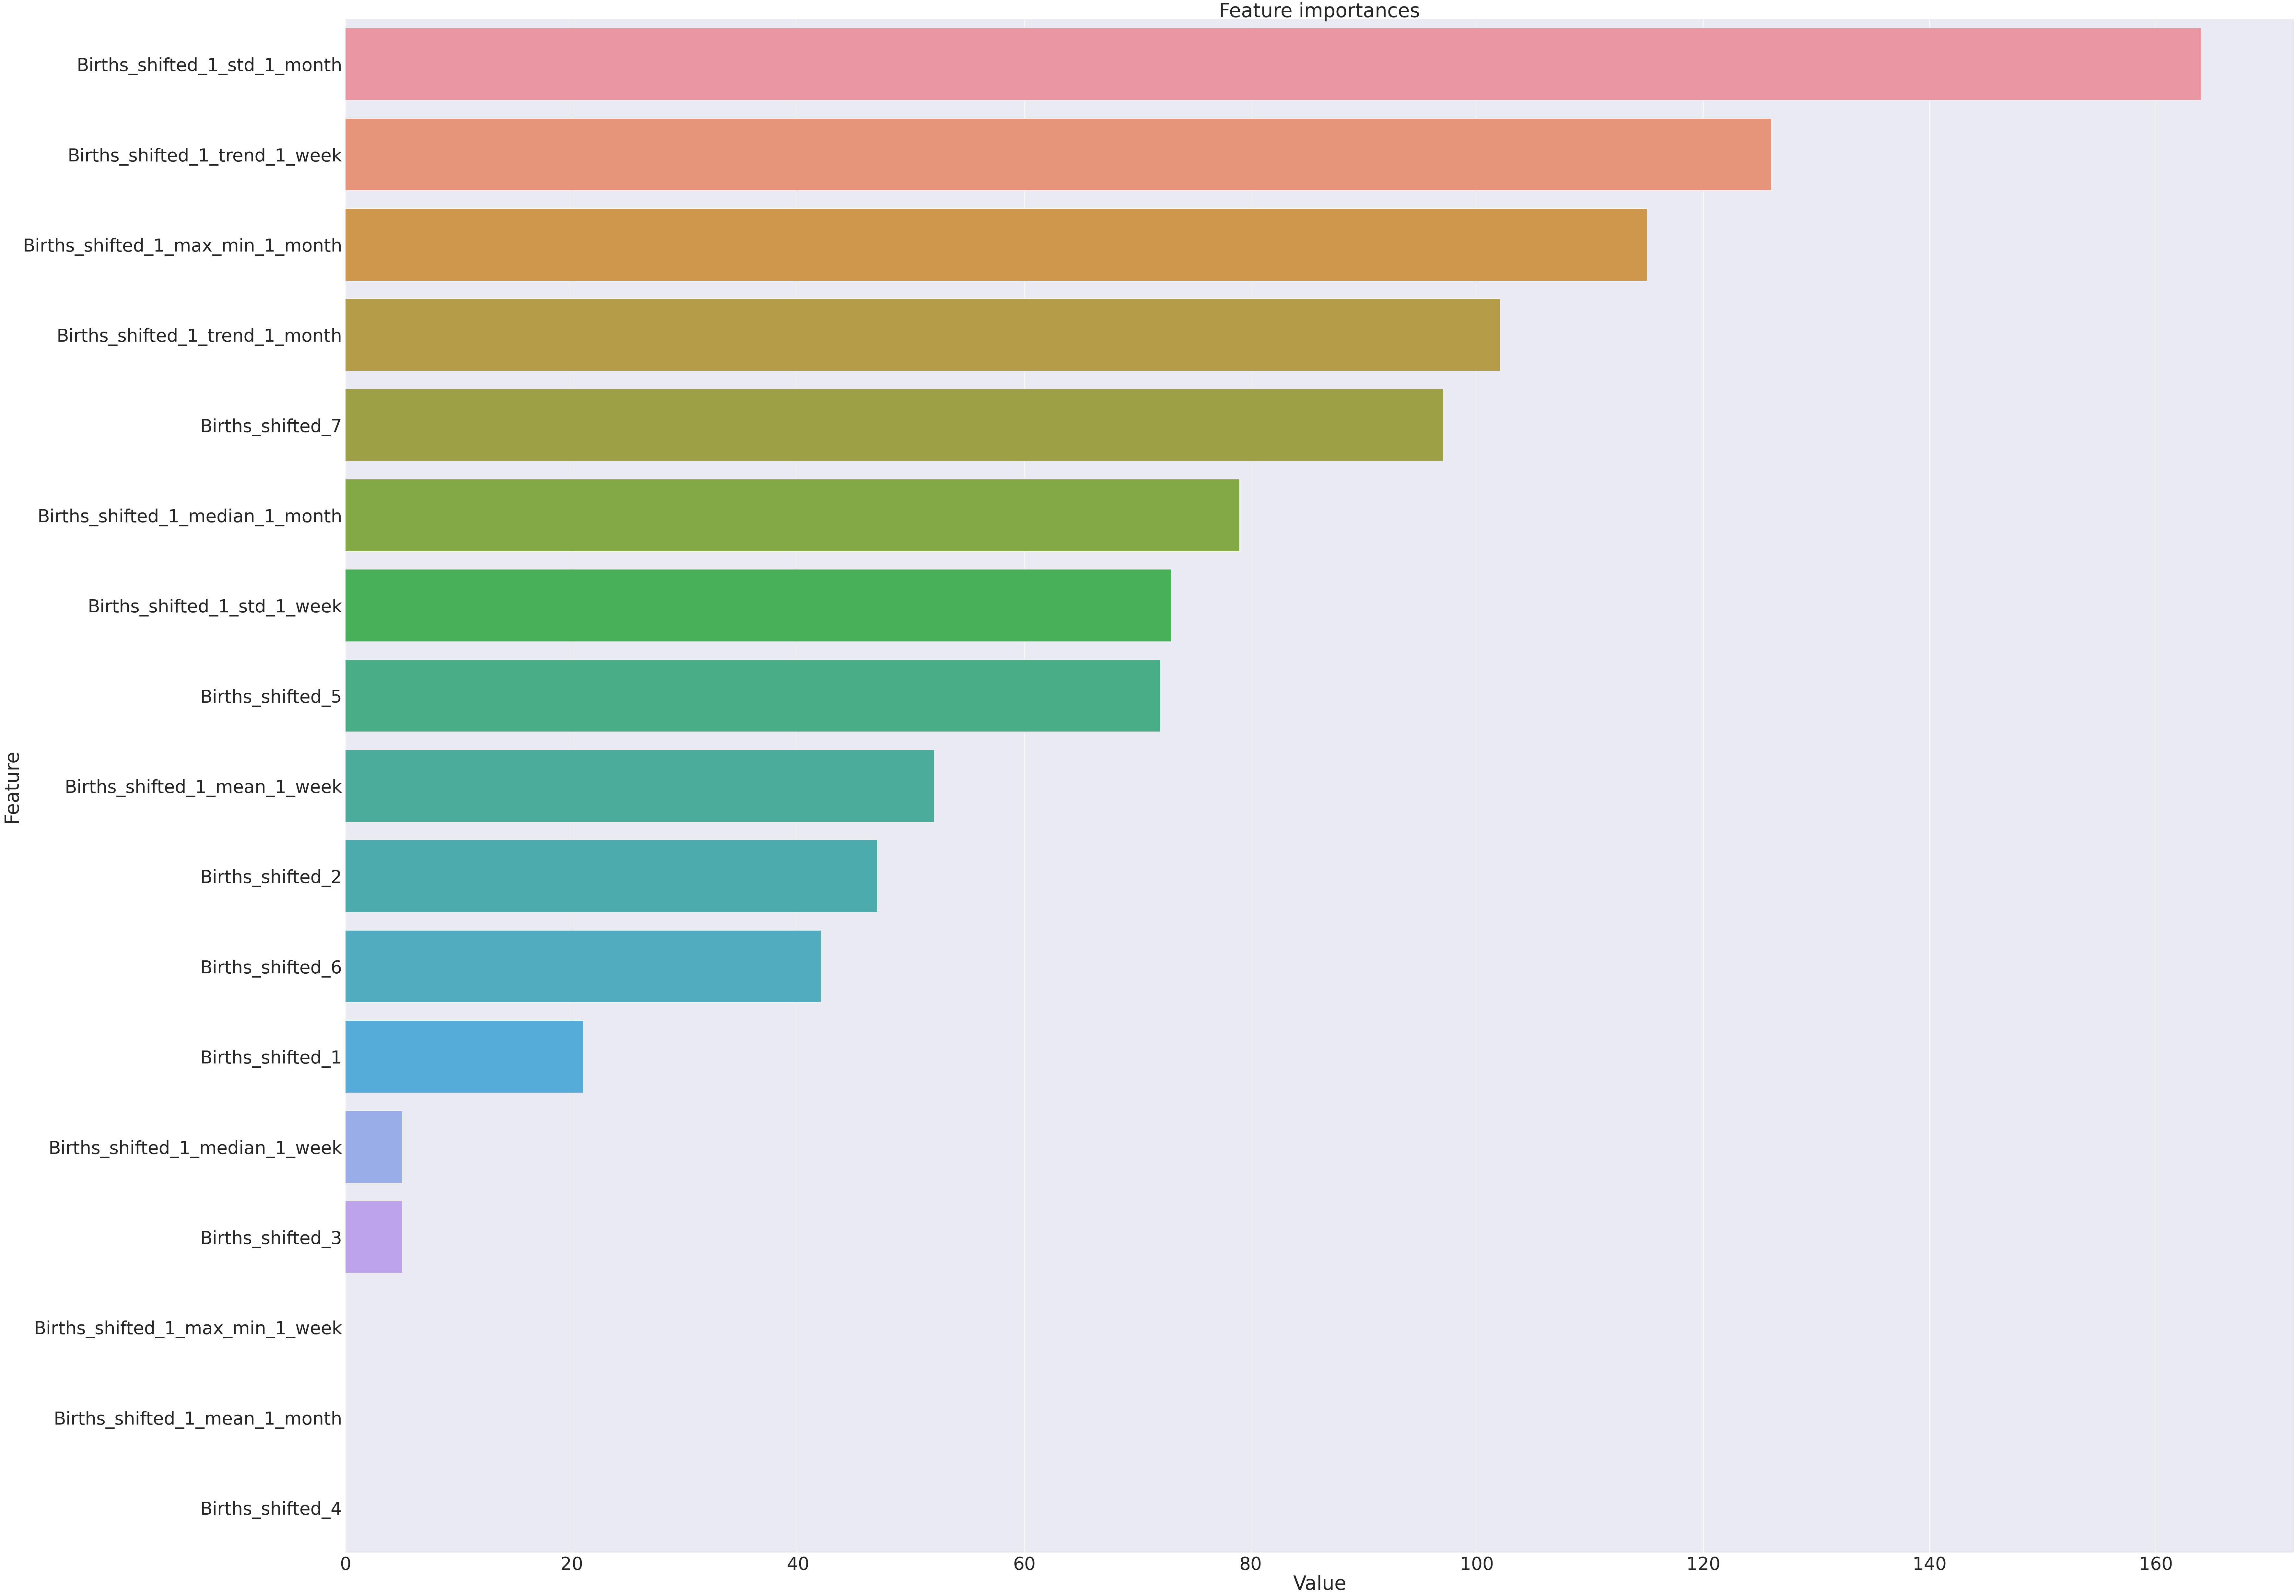

In [ ]:
plot_importance(feats_importance)

In [ ]:
linreg = LinearRegression()

linreg.fit(x_train, y_train)

print('LGBM best mse:', round(all_mse, 5))
print('Linreg mse:   ', round(mean_squared_error(y_test, linreg.predict(x_test)), 5))

LGBM best mse: 48.03631
Linreg mse:    50.63171


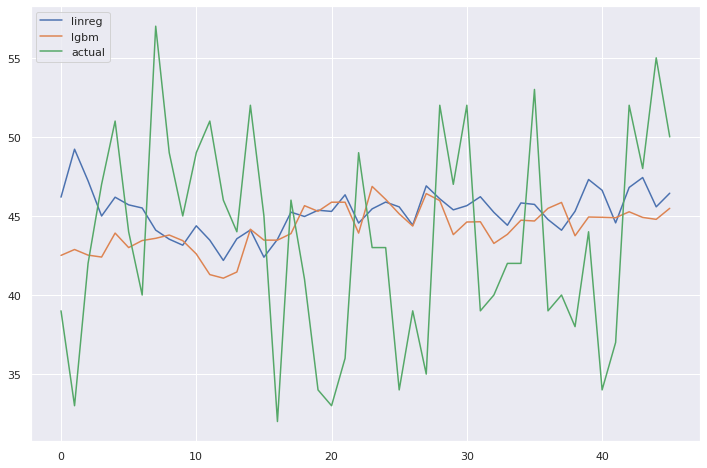

In [ ]:
sns.set(font_scale=1)
size = 365
plt.figure(figsize=(12, 8))
plt.plot(linreg.predict(x_test)[:size], label='linreg')
plt.plot(model.predict(x_test)[:size], label='lgbm')
plt.plot(y_test.reset_index(drop=True)[:size], label='actual')
plt.legend()
plt.show()

### Добавляем временные признаки

In [ ]:
x = backup.copy()
x['Births'] = x['Births'].shift(-30)
x = x.dropna()

dates = pd.to_datetime(x['Date'])
x['day'] = dates.dt.day
x['dayofweek'] = dates.dt.dayofweek
x['month'] = dates.dt.month
x['dayofyear'] = dates.dt.dayofyear
y = x['Births']
del x['Births']

In [ ]:
split_train_size = 0.7
split_val_size = 0.85

train_quantile = dates.quantile(split_train_size)
val_quantile = dates.quantile(split_val_size)

x_train = x[dates < train_quantile]
y_train = y[dates < train_quantile]

x_val = x[(dates >= train_quantile) & (dates < val_quantile)]
y_val = y[(dates >= train_quantile) & (dates < val_quantile)]

x_test = x[dates > val_quantile]
y_test = y[dates > val_quantile]

print(f'Train      from {x_train.Date.min()} to {x_train.Date.max()}')
print(f'Validation from {x_val.Date.min()} to {x_val.Date.max()}')
print(f'Test       from {x_test.Date.min()} to {x_test.Date.max()}')

del x_train['Date']
del x_val['Date']
del x_test['Date']

Train      from 1959-01-31 to 1959-08-31
Validation from 1959-09-01 to 1959-10-15
Test       from 1959-10-16 to 1959-11-30


In [ ]:
train_mat = lgb.Dataset(x_train, label=y_train)
val_mat = lgb.Dataset(x_val, label=y_val)

params = {
    'metric': 'mse', 
    'objective': 'mse', 
    'feature_fraction': 1,
    'learning_rate': 0.01,
    'force_row_wise': True
}

model = lgb.train(
    params,
    train_mat,
    valid_sets=[train_mat, val_mat],
    num_boost_round=1000,
    verbose_eval=50,
    early_stopping_rounds=100
)

all_mse = mean_squared_error(y_test, model.predict(x_test))
feats_importance = model.feature_importance()

Training until validation scores don't improve for 100 rounds.
[50]	training's l2: 44.726	valid_1's l2: 39.2687
[100]	training's l2: 38.3281	valid_1's l2: 42.8889
Early stopping, best iteration is:
[39]	training's l2: 46.421	valid_1's l2: 39.0227


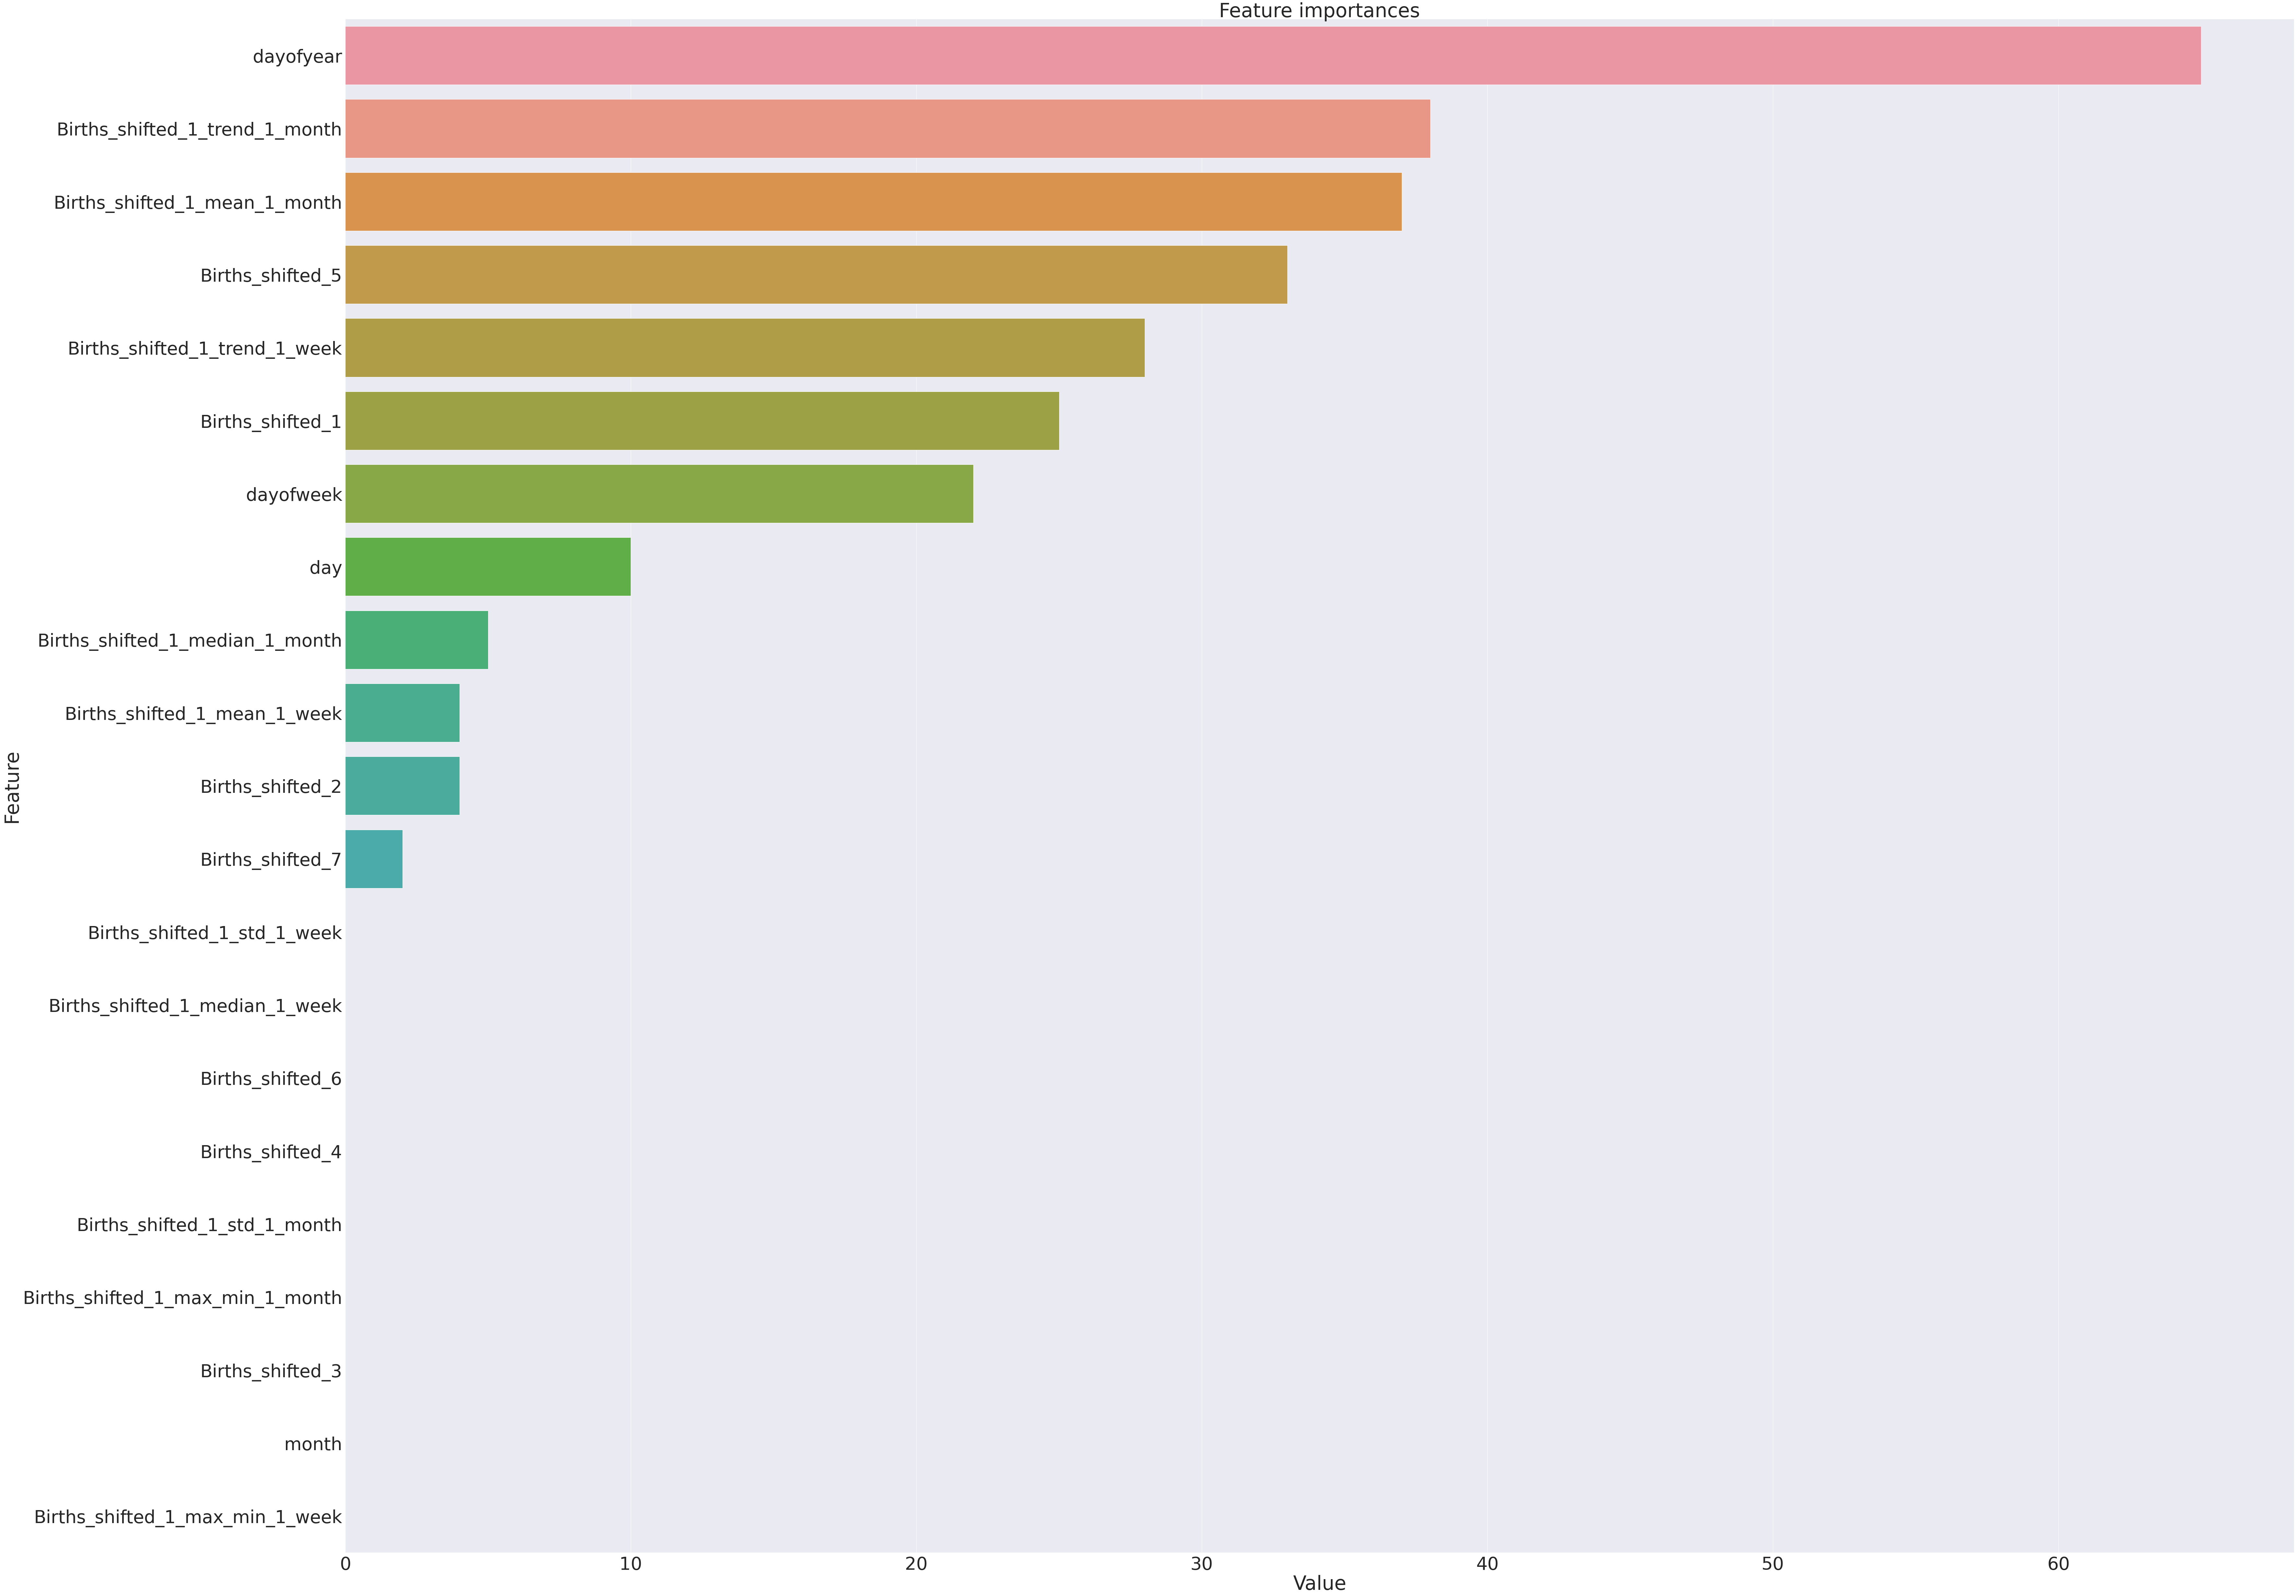

In [ ]:
plot_importance(feats_importance)

In [ ]:
linreg = LinearRegression()

linreg.fit(x_train, y_train)

print('LGBM best mse:', round(all_mse, 5))
print('Linreg mse:   ', round(mean_squared_error(y_test, linreg.predict(x_test)), 5))

LGBM best mse: 42.70447
Linreg mse:    73.66747
